In [4]:
import logging

import numpy as np
import optimistix as optx
from atmodeller import (
    InteriorAtmosphere,
    Planet,
    Species,
    SpeciesCollection,
    debug_logger,
    earth_oceans_to_hydrogen_mass,
    SolverParameters,
)
from atmodeller.eos import get_eos_models
from atmodeller.solubility import get_solubility_models
from atmodeller.thermodata import IronWustiteBuffer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LogNorm

from scipy.interpolate import interp1d
import os

from matplotlib.ticker import ScalarFormatter

formatter = ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

logger = debug_logger() #you can dump it in file 
#logger.setLevel(logging.INFO) #you could set it to error

logger.setLevel(logging.DEBUG)  
##rebase for atmodeller git pull, git re base (you might also have to git pull when paralell)

Atmodeller initialized with double precision (float64)


# Case 1

In [18]:
#Overall structure 
R_earth = 6.371e6
R_uranus = 2.5388e7 #meters
M_earth = 5.972e24 #kg
M_uranus = 14.536*M_earth

#Boundary inner and outer envelope
M_until_inner_envelope = 0.913*M_uranus 
R_inner_envelope = 0.772*R_uranus
inner_envelope_temperature = 2338.8
inner_en_core_mass_fraction = 0
boundary_mantle_melt_fraction = 0

#Core 
M_core = 0.61*M_earth 
core_mass_fraction_U = 0
core_mantle_melt_fraction = 1.0
R_core = 0.7*R_earth 
core_temperature = 6000

M_heavy = 12.4*M_earth

Z_1 = 0.17
Z_2 = 0.915
Z_solar = 0.0142
print(Z_2/Z_solar)
ice_rock_ratio = 19

64.43661971830986


In [6]:
M_inner_envelope = M_until_inner_envelope - M_core
M_outer_envelope = M_uranus - M_until_inner_envelope

M_rock = M_heavy / (1+ice_rock_ratio)
M_ice = M_heavy - M_rock 

M_H_He_outer_envelope = (1-Z_1)*M_outer_envelope
M_H_He_inner_envelope = (1-Z_2)*M_inner_envelope
M_H_He_envelope = M_H_He_outer_envelope + M_H_He_inner_envelope
print(M_H_He_envelope / M_earth)
print(M_outer_envelope/ M_earth)
print(M_inner_envelope/ M_earth)

2.12586084
1.2646320000000006
12.661368


In [9]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction_U)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme141: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999

MgO_mantlemasspercent_palme14: float = 36.77
Mg_massfraction_palme14: float = round(
    MgO_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction_U)
    / (24.305 + 15.999)
    * 24.305,
    3,
)
O_massfraction_palme142: float = Mg_massfraction_palme14 / 24.305 * 15.999
O_massfraction_palme14 = O_massfraction_palme141 + O_massfraction_palme142
print(O_massfraction_palme14)
print(Si_massfraction_palme14)

0.394198674005231
0.216


In [15]:
Z_CH4 = 0.31
Z_NH3 = 0.08
Z_H2O = np.linspace(0.6,1, 100)
Z_H2O = 0.61


print(Z_H2O)
o_kgs_perc = Z_H2O *  15.999 / ( 15.999 + 2 * 1.00794)
h_kgs_perc = Z_H2O *  2 * 1.00794 / ( 15.999 + 2 * 1.00794) + Z_NH3 * 3 * 1.00794 / ( 14.0067 + 3 * 1.00794) #+ Z_CH4 * 4 * 1.00794 / ( 12.0107 + 4 * 1.00794)
n_kgs_perc = Z_NH3 * 14.0067 / ( 14.0067 + 3 * 1.00794)
c_kgs_perc = Z_CH4 * 12.0107 / ( 12.0107 + 4 * 1.00794)

o_kgs_ice = o_kgs_perc*M_ice
h_kgs_ice = h_kgs_perc*M_ice
n_kgs_ice = n_kgs_perc*M_ice
c_kgs_ice = c_kgs_perc*M_ice

print(o_kgs_perc)
print(h_kgs_perc)
print(n_kgs_perc)
print(c_kgs_perc)

0.61
0.5417404945245263
0.08246374586273131
0.0657957596127423
0.23209139994738961


In [16]:
M_H = h_kgs_ice + 0.725*M_H_He_envelope
M_He = 0.275*M_H_He_envelope
M_O = o_kgs_ice + M_rock*O_massfraction_palme14
M_Si = M_rock*Si_massfraction_palme14
M_Mg = M_rock*Mg_massfraction_palme14
M_C = c_kgs_ice
M_N = n_kgs_ice
print(M_H)
print(M_He)
print(M_O)
print(M_Si)
print(M_Mg)
print(M_C)
print(M_N)

1.5005677394590487e+25
3.491301257532001e+24
3.957110624659829e+25
7.9977024e+23
8.33094e+23
1.6327667120922852e+25
4.6287422160779586e+24


In [13]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

CO2_g = Species.create_gas("CO2")
CO2_gs = Species.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = Species.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)
#
CO_g = Species.create_gas("CO")
CO_gs = Species.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = Species.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)
#
CH4_g = Species.create_gas("CH4")
CH4_gs = Species.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = Species.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)
#
N2_g = Species.create_gas("N2")
N2_gs = Species.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = Species.create_gas(
    "N2",solubility=sol_models["N2_basalt_libourel03"],activity=eos_models["N2_cs_saxena87"]
)

NH3_g = Species.create_gas("NH3")
NH3_rg = Species.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = Species.create_gas("He")
He_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = Species.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)

Mg_g = Species.create_gas("Mg")
#Mg_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
#Mg_rgs = Species.create_gas(
#    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
#)

MgO_l = Species.create_condensed("MgO", state="l")
MgO_cr = Species.create_condensed("MgO", state="cr")
MgH_g = Species.create_gas("MgH")
MgOH_g = Species.create_gas("MgOH")

species_HHeCNOSi_magma_nosol_ideal = SpeciesCollection(
    (H2O_g, H2_g, O2_g, OSi_g, H4Si_g,N2_g, NH3_g, O2Si_l, He_g)
     #)
)
species_HHeCNOSi_magma_sol_ideal = SpeciesCollection(
    (H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g,N2_gs, NH3_g, O2Si_l, He_gs)
     #, )
)
species_HHeCNOSi_magma_sol_real = SpeciesCollection(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
#        CO2_rgs,
#        CO_rgs,
#        CH4_rgs,
        N2_rgs,
        NH3_rg,
        He_rgs
    )
)

In [17]:
mass_constraints = {
    "H": M_H,
    "He": M_He,
#    "C": M_C,
    "N": M_N,
    "Si":  M_Si,
    "O": M_O,
#    "Mg": metall * mg_kgs_solar + core_mantle_melt_fraction * mg_kg_magma,
        }
#solver = optx.LevenbergMarquardt, 
solver_parameters = SolverParameters(multistart= 50)
Uranus = Planet(
    surface_temperature=4500,
    planet_mass=M_core,
    mantle_melt_fraction=core_mantle_melt_fraction,
    core_mass_fraction = core_mass_fraction_U,
    surface_radius=R_core,
    )

model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
model_magma_nosol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        )
output_magma_nosol_ideal = model_magma_nosol_ideal.output
output_magma_nosol_ideal.quick_look()
output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
initial_log_number_density = output_magma_nosol_ideal.log_number_density
model_magma_sol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_ideal = model_magma_sol_ideal.output
output_magma_sol_ideal.quick_look()
output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

#last minute solution, reverting to other solver 
model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
initial_log_number_density = output_magma_sol_ideal.log_number_density
model_magma_sol_real.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        solver_parameters= solver_parameters,
        initial_log_number_density=initial_log_number_density
        )
output_magma_sol_real = model_magma_sol_real.output
output_magma_sol_real.quick_look()
output_magma_sol_real.to_excel("Core_HHeSiO_Testnew")

[13:40:54 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'He_g: IdealGas, NoSolubility')
[13:40:54 - atmodeller.classes             - INFO     ] - reactions = {0: '1.3333333333333333 H2O_g + 0.6666666666666667 OSi_g = 1.0 O2_g + '
    '0.6666666666666666 H4Si_g',
 1: '0.5 H2O_g + 0.5 H4Si_g + 0.5 N2_g = 0.5 OSi_g + 1.0 H3N_g',
 2: '0.6666666666666666 H2O_g + 1.3333333333333335 OSi_g = 0.3333333333333333 '
    'H4Si_g + 1.0 O2Si_l',
 3: '0.33333333333333337 H2O_g + 0.3333333333333333 H4Si_g = 1.0 H2_g + '
    '0.33333333333333337 OSi_g'}
[13:40:54 - atmodeller.classes             - INFO     ] - Attempting to solve 1 model(s)
[13:40:56 - atmodeller.classes             - INFO     ] - Solve complete: 1 (100.00

In [16]:
H2_pressure_magma_sol_real = []
H2O_pressure_magma_sol_real = []
O2_pressure_magma_sol_real = []
SiH4_pressure_magma_sol_real = []
SiO_pressure_magma_sol_real = []
He_pressure_magma_sol_real = []
tot_pressure_magma_sol_real = []

H_moles_atm_magma_sol_real = []
O_moles_atm_magma_sol_real = []
Si_moles_atm_magma_sol_real = []
He_moles_atm_magma_sol_real = []

H_moles_melt_magma_sol_real = []
O_moles_melt_magma_sol_real = []
Si_moles_melt_magma_sol_real = []
He_moles_melt_magma_sol_real = []

H_moles_tot_magma_sol_real = []
O_moles_tot_magma_sol_real = []
Si_moles_tot_magma_sol_real = []
He_moles_tot_magma_sol_real = []

H_mass_atm_magma_sol_real = []
O_mass_atm_magma_sol_real = []
Si_mass_atm_magma_sol_real = []
He_mass_atm_magma_sol_real = []

H_mass_melt_magma_sol_real = []
O_mass_melt_magma_sol_real = []
Si_mass_melt_magma_sol_real = []
He_mass_melt_magma_sol_real = []

H_mass_tot_magma_sol_real = []
O_mass_tot_magma_sol_real = []
Si_mass_tot_magma_sol_real = []
He_mass_tot_magma_sol_real = []

In [18]:
Temperatures = list(range(3200, 4651, 50))
for T in Temperatures:
    filename = f"Core_HHeSiO_{Temperature}.xlsx"

    H2_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="H2_g")["pressure"])
    H2O_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="H2O_g")["pressure"])
    O2_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="O2_g")["pressure"])
    SiH4_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="H4Si_g")["pressure"])
    SiO_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="OSi_g")["pressure"])
    He_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="He_g")["pressure"])
    tot_pressure_magma_sol_real.append(pd.read_excel(filename, sheet_name="atmosphere")["pressure"])

    H_moles_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_H")["atmosphere_moles"])
    O_moles_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_O")["atmosphere_moles"])
    Si_moles_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_Si")["atmosphere_moles"])
    He_moles_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_He")["atmosphere_moles"])

    H_moles_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_H")["dissolved_moles"])
    O_moles_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_O")["dissolved_moles"])
    Si_moles_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_Si")["dissolved_moles"])
    He_moles_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_He")["dissolved_moles"])

    H_moles_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_H")["total_moles"])
    O_moles_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_O")["total_moles"])
    Si_moles_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_Si")["total_moles"])
    He_moles_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_He")["total_moles"])

    H_mass_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_H")["atmosphere_mass"])
    O_mass_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_O")["atmosphere_mass"])
    Si_mass_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_Si")["atmosphere_mass"])
    He_mass_atm_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_He")["atmosphere_mass"])

    H_mass_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_H")["dissolved_mass"])
    O_mass_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_O")["dissolved_mass"])
    Si_mass_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_Si")["dissolved_mass"])
    He_mass_melt_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_He")["dissolved_mass"])

    H_mass_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_H")["total_mass"])
    O_mass_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_O")["total_mass"])
    Si_mass_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_Si")["total_mass"])
    He_mass_tot_magma_sol_real.append(pd.read_excel(filename, sheet_name="element_He")["total_mass"])

In [23]:
color_tot = "black"
color_H2 = "orange"
color_H2O = "blue"
color_SiH4 = "red"
color_SiO = "brown"
color_O2 = "limegreen"
color_CO2 = "cyan"
color_CO = "magenta"
color_CH4 = "purple"
color_N2 = "green"
color_NH3 = "pink"
color_MgO = "darkred"
color_He = "gray"
color_H = "orange"
color_C = "cyan"
color_N = "green"
color_O = "blue"
color_Si = "red"
color_Mg = "lime"
color_MgH2 = "gold"
color_MgH = "teal"
color_MgOH = "indigo"

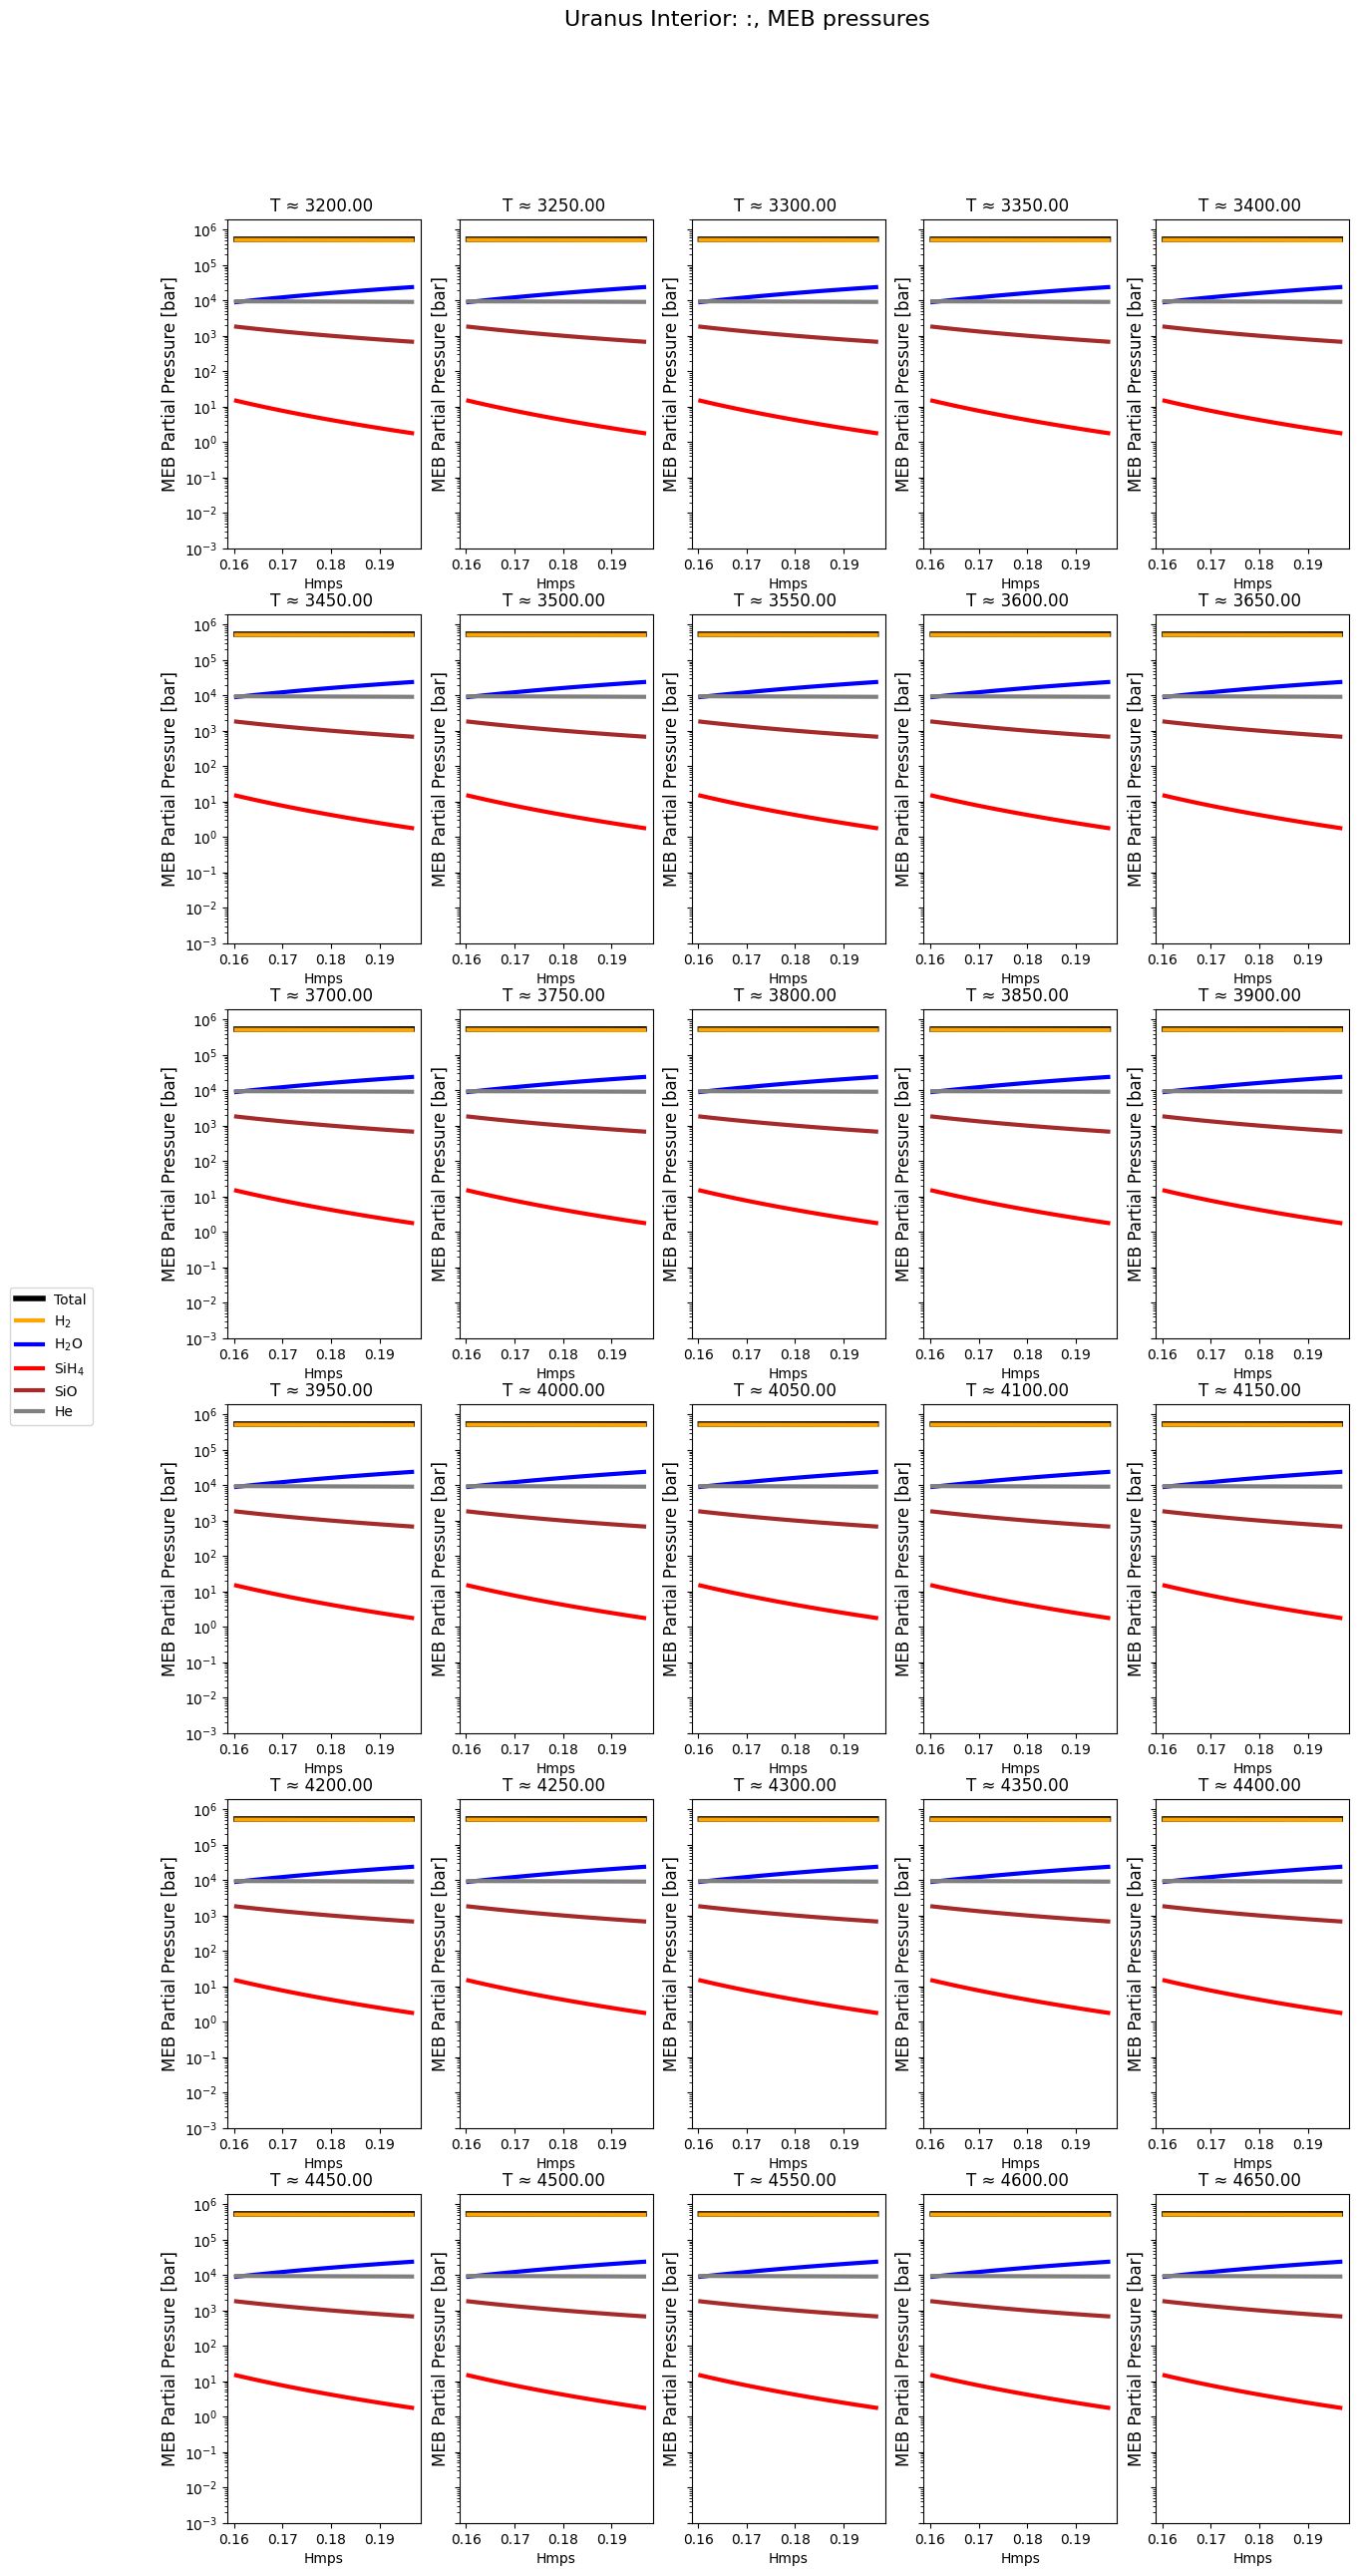

In [29]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], tot_pressure_magma_sol_real[i], color=color_tot, lw=4, ls="-", label="Total")
    ax.plot(Hmps[i], H2_pressure_magma_sol_real[i], color=color_H2, lw=3, ls="-", label="H$_2$")
    ax.plot(Hmps[i], H2O_pressure_magma_sol_real[i], color=color_H2O, lw=3, ls="-", label="H$_2$O")
    ax.plot(Hmps[i], SiH4_pressure_magma_sol_real[i], color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    ax.plot(Hmps[i], SiO_pressure_magma_sol_real[i], color=color_SiO, lw=3, ls="-", label="SiO")
    ax.plot(Hmps[i], He_pressure_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], tot_pressure_magma_sol_real[i], color=color_tot, lw=3, ls="-", label="tot")

    ax.set_title(r"(a) Real gas")
    ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{T:.0f}"
    filename = f"./Test_constraints_images/uranus_{T:.0f}_MEB_pressures.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], tot_pressure_magma_sol_real[i], color=color_tot, lw=4, ls="-", label="Total")
    axes[i].plot(Hmps[i], H2_pressure_magma_sol_real[i], color=color_H2, lw=3, ls="-", label="H$_2$")
    axes[i].plot(Hmps[i], H2O_pressure_magma_sol_real[i], color=color_H2O, lw=3, ls="-", label="H$_2$O")
    axes[i].plot(Hmps[i], SiH4_pressure_magma_sol_real[i], color=color_SiH4, lw=3, ls="-", label="SiH$_4$")
    axes[i].plot(Hmps[i], SiO_pressure_magma_sol_real[i], color=color_SiO, lw=3, ls="-", label="SiO")
    axes[i].plot(Hmps[i], He_pressure_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
    axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"MEB Partial Pressure [bar]", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, MEB pressures ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_MEB_pressures.png", dpi=300, bbox_inches='tight')

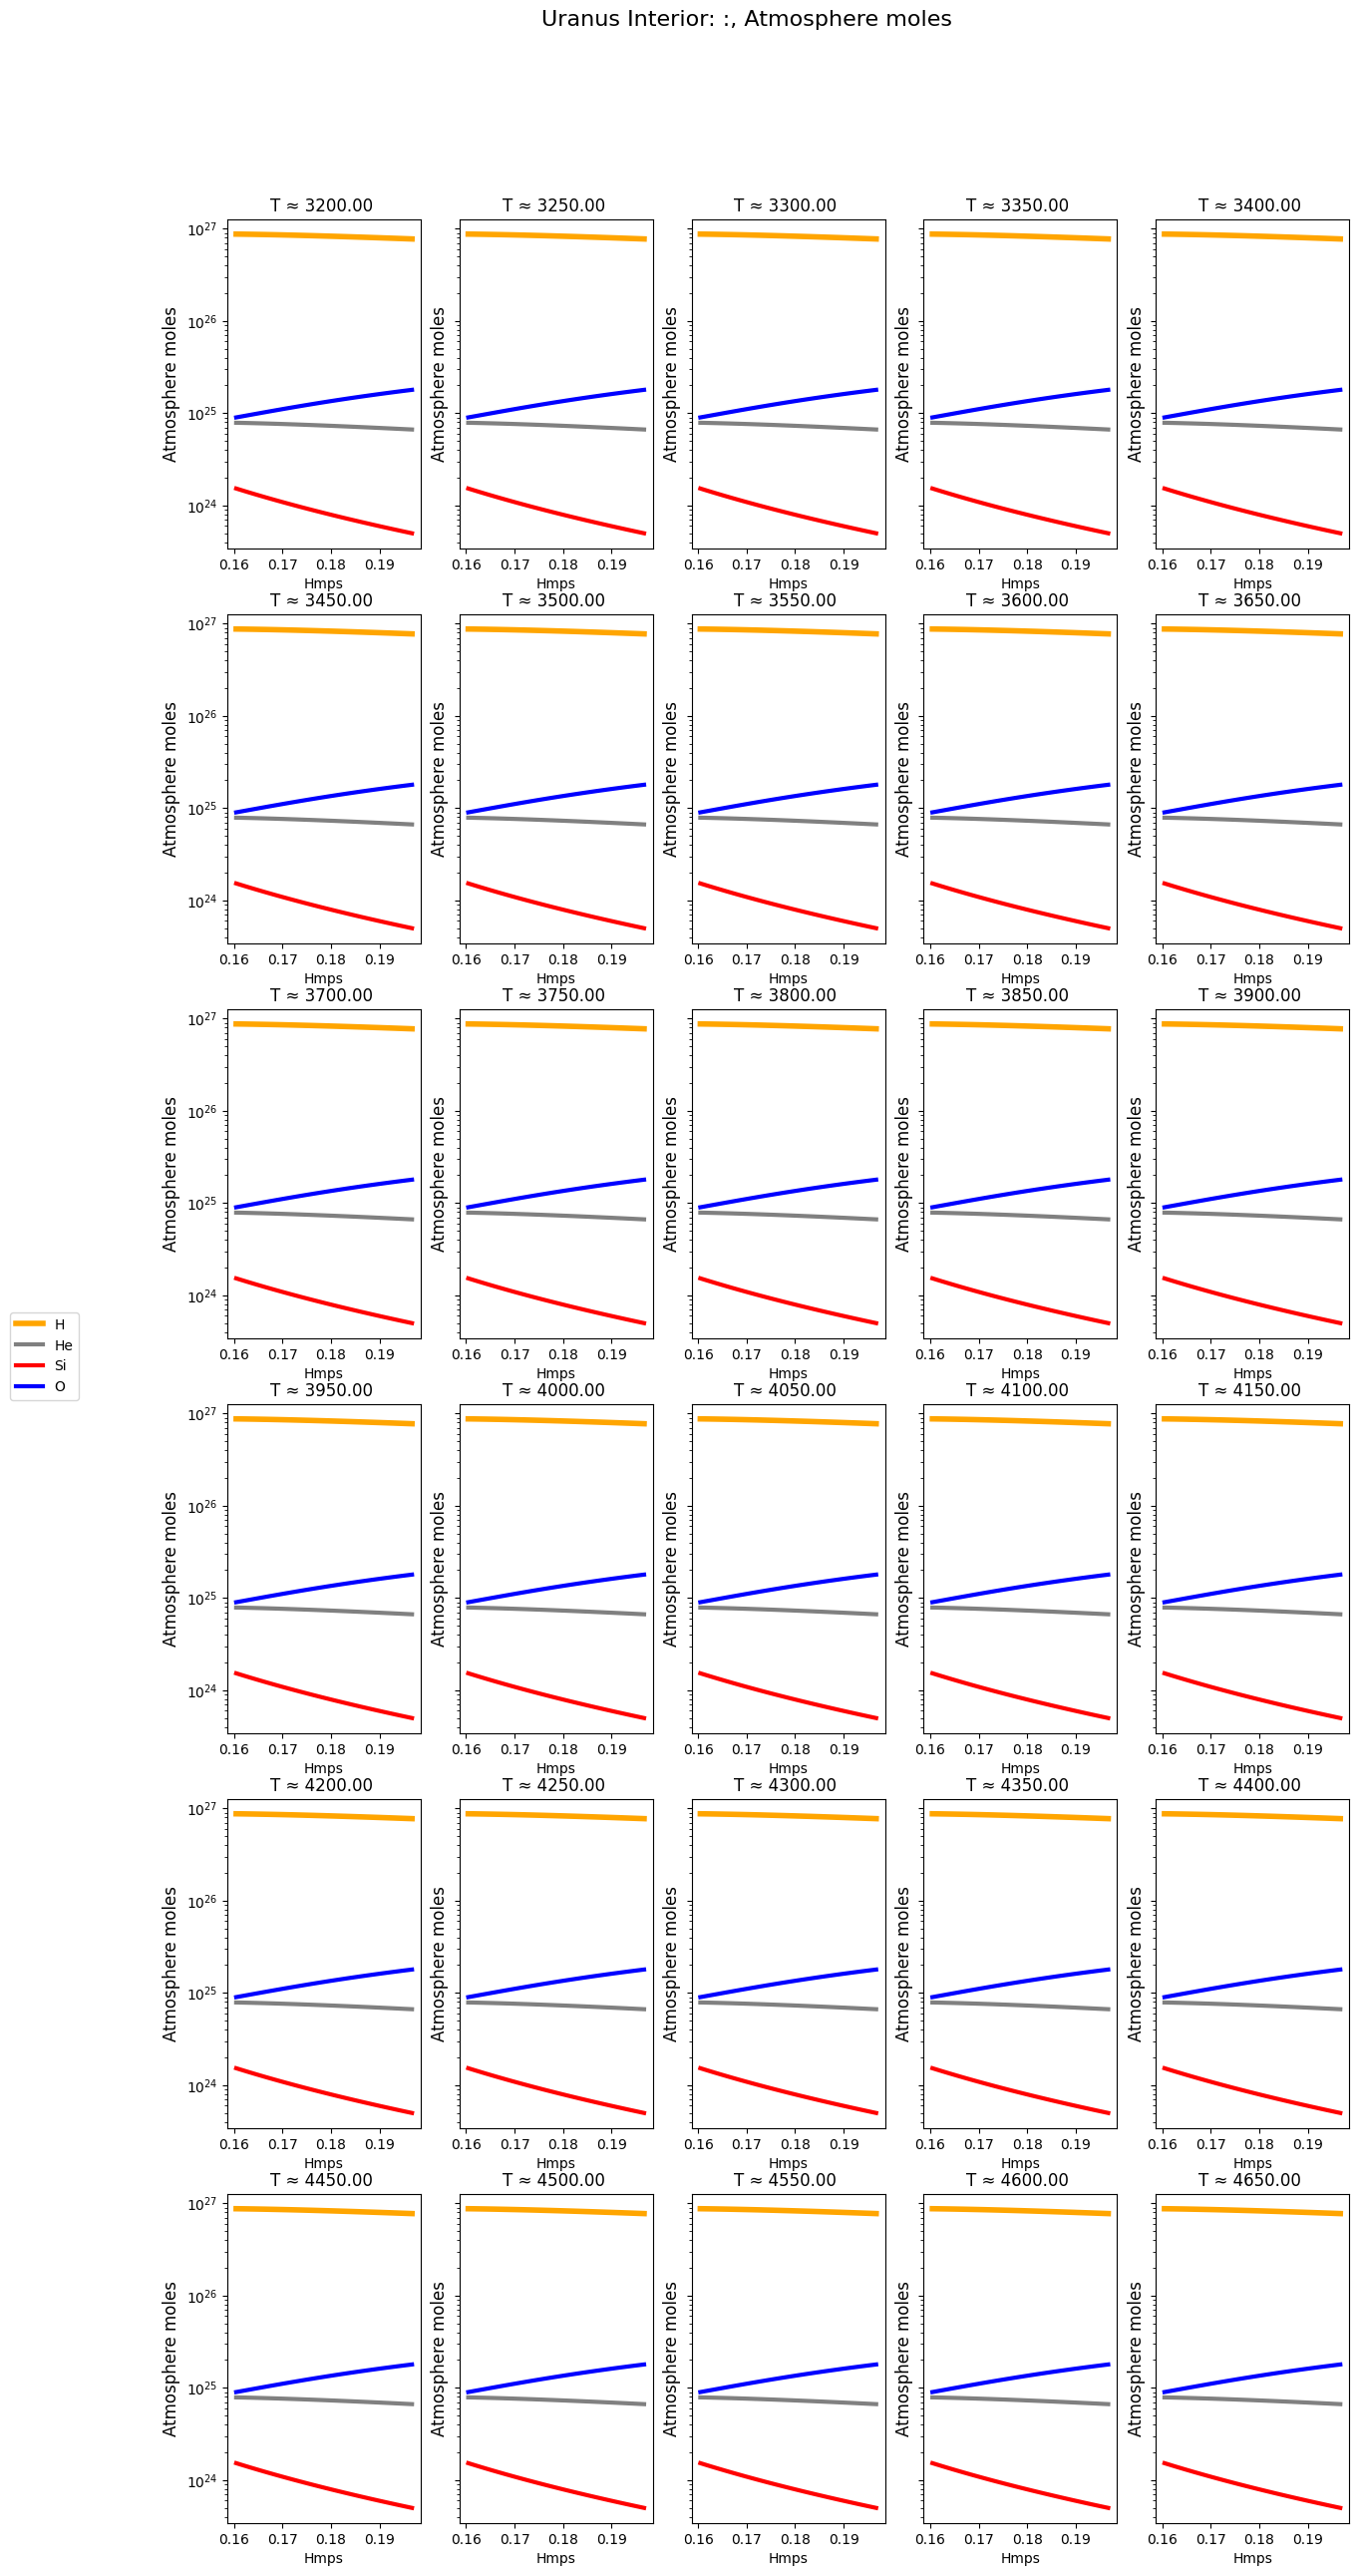

In [31]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], H_moles_atm_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    ax.plot(Hmps[i], He_moles_atm_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], Si_moles_atm_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(Hmps[i], O_moles_atm_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    ax.set_title(r"(a) Real gas")
    #ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"Atmosphere moles", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{T:.0f}"
    filename = f"./Test_constraints_images/uranus_{T:.0f}_Atmosphere_moles.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], H_moles_atm_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(Hmps[i], He_moles_atm_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(Hmps[i], Si_moles_atm_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(Hmps[i], O_moles_atm_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
    #axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"Atmosphere moles", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, Atmosphere moles ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_atmo_moles.png", dpi=300, bbox_inches='tight')

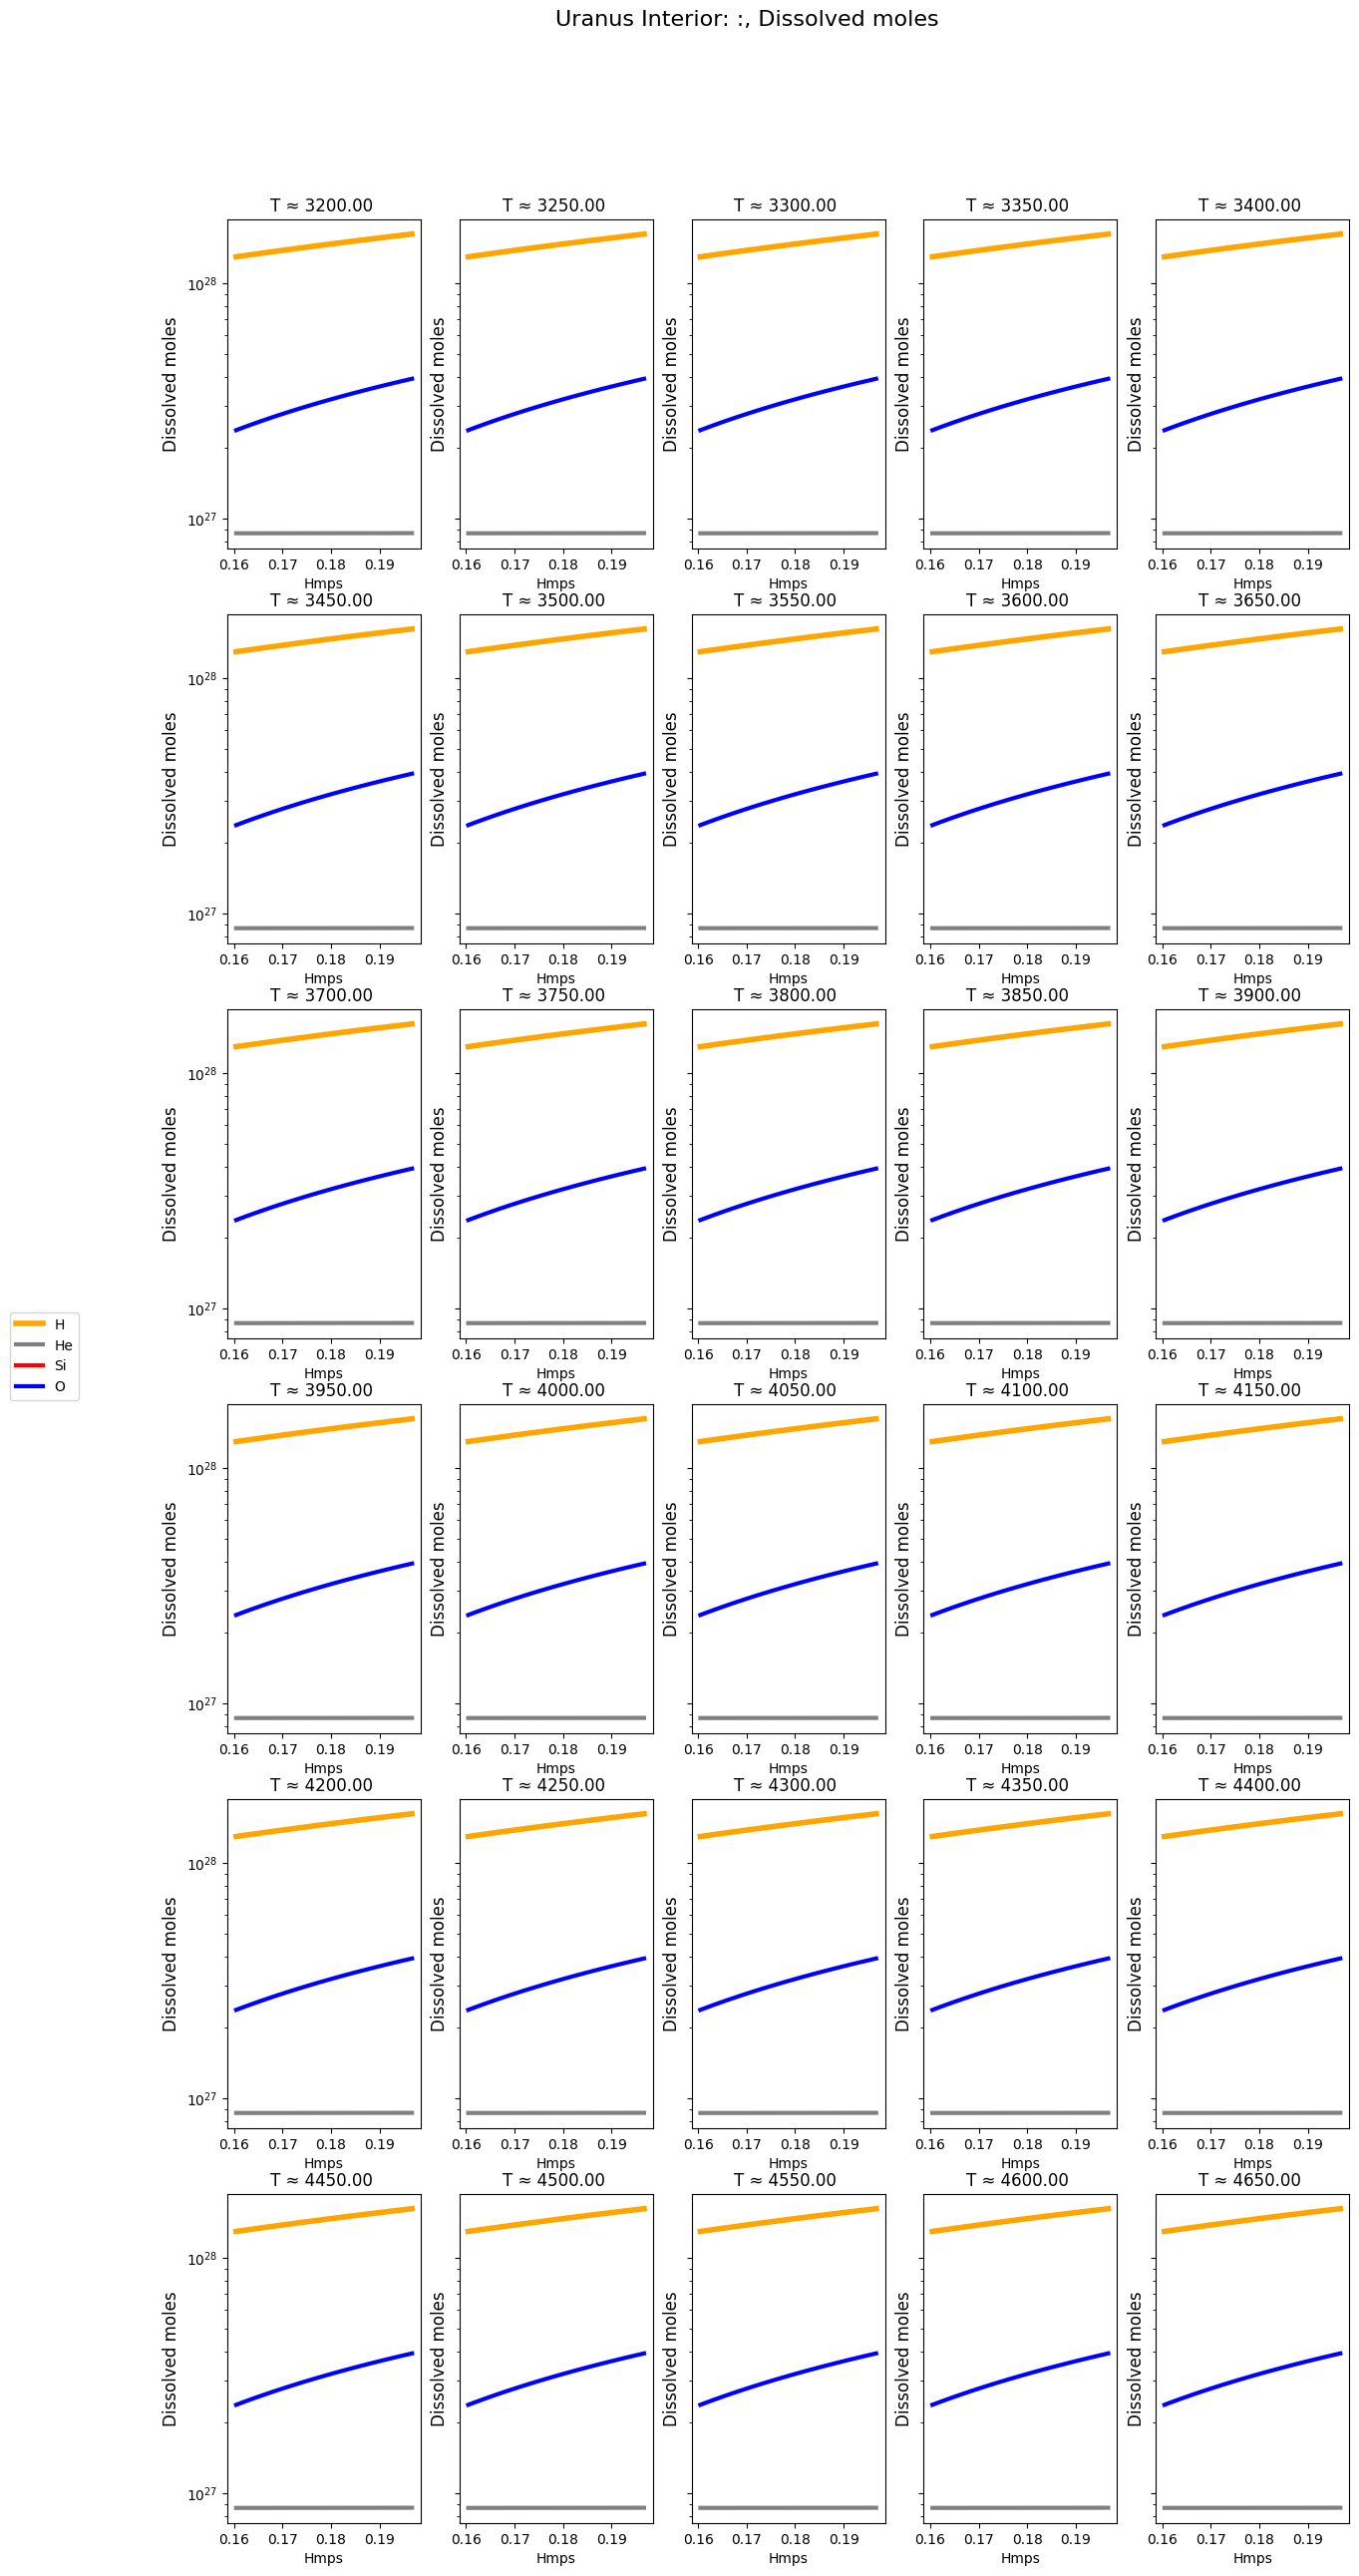

In [36]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], H_moles_melt_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    ax.plot(Hmps[i], He_moles_melt_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], Si_moles_melt_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(Hmps[i], O_moles_melt_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    ax.set_title(r"(a) Real gas")
#    ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"Dissolved moles", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{T:.0f}"
    filename = f"./Test_constraints_images/uranus_{T:.0f}_dissolved_moles.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], H_moles_melt_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(Hmps[i], He_moles_melt_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(Hmps[i], Si_moles_melt_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(Hmps[i], O_moles_melt_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
#    axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"Dissolved moles", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, Dissolved moles ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_melt_moles.png", dpi=300, bbox_inches='tight')

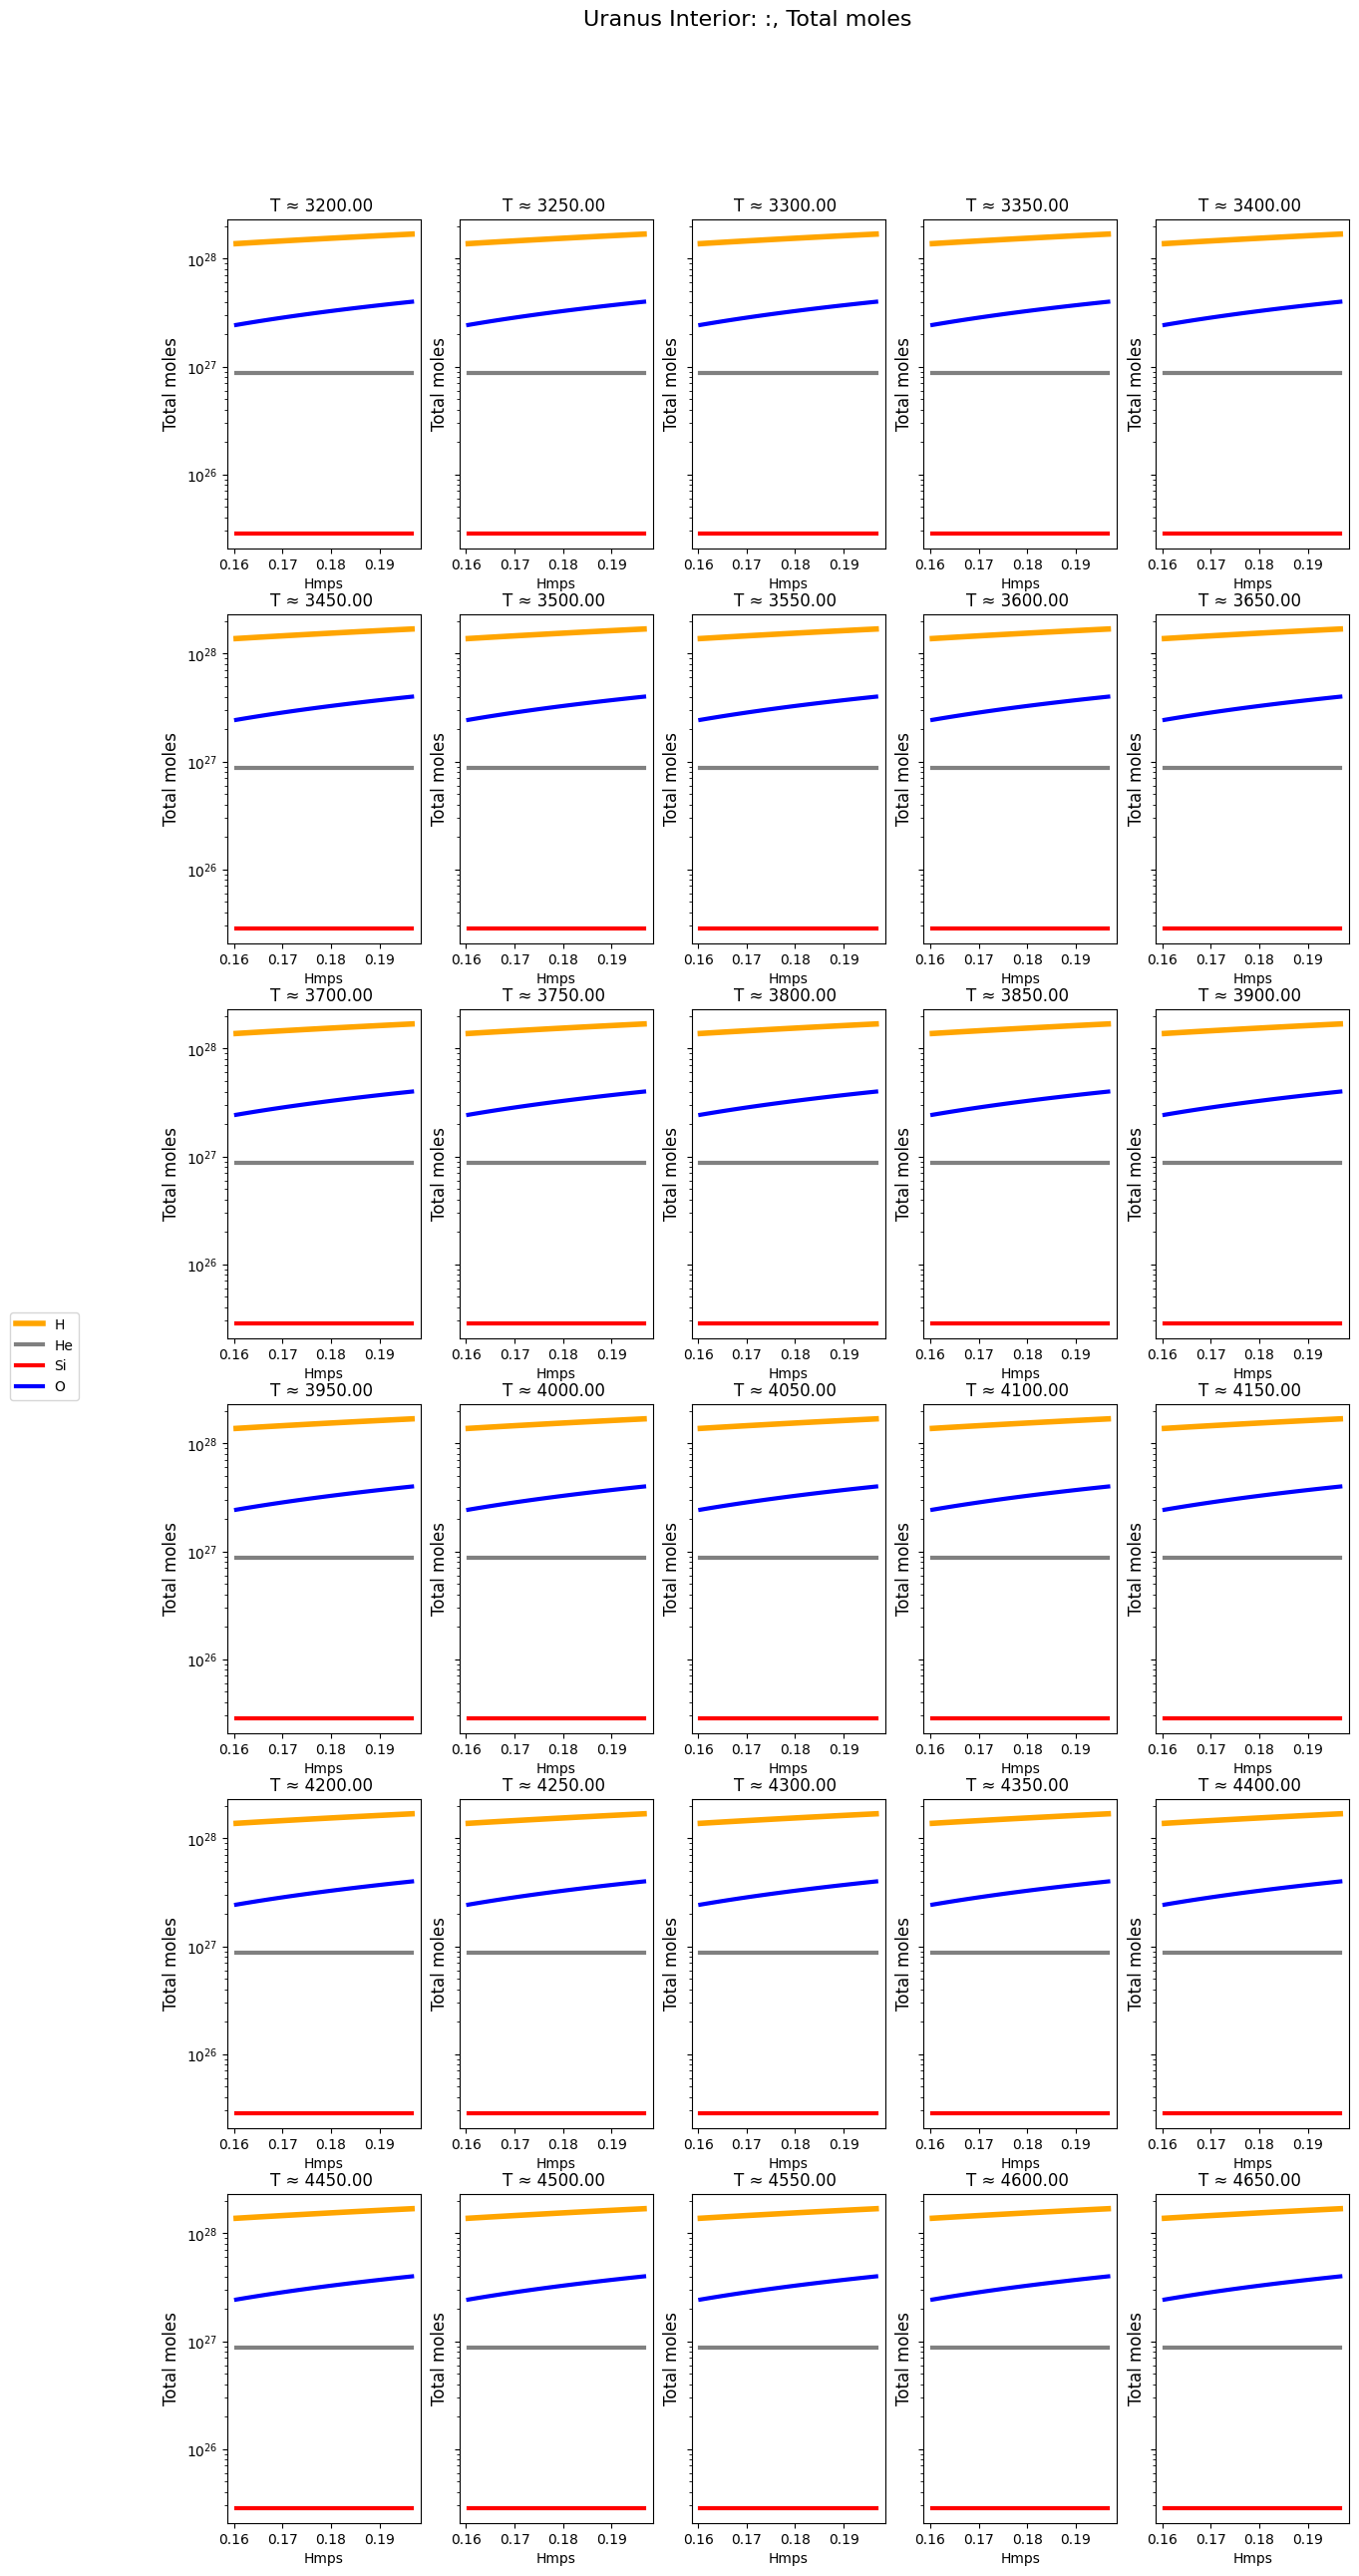

In [37]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], H_moles_tot_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    ax.plot(Hmps[i], He_moles_tot_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], Si_moles_tot_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(Hmps[i], O_moles_tot_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    ax.set_title(r"(a) Real gas")
#    ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"Total moles", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{T:.0f}"
    filename = f"./Test_constraints_images/uranus_{T:.0f}_total_moles.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], H_moles_tot_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(Hmps[i], He_moles_tot_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(Hmps[i], Si_moles_tot_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(Hmps[i], O_moles_tot_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
#    axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"Total moles", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, Total moles ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_tot_moles.png", dpi=300, bbox_inches='tight')

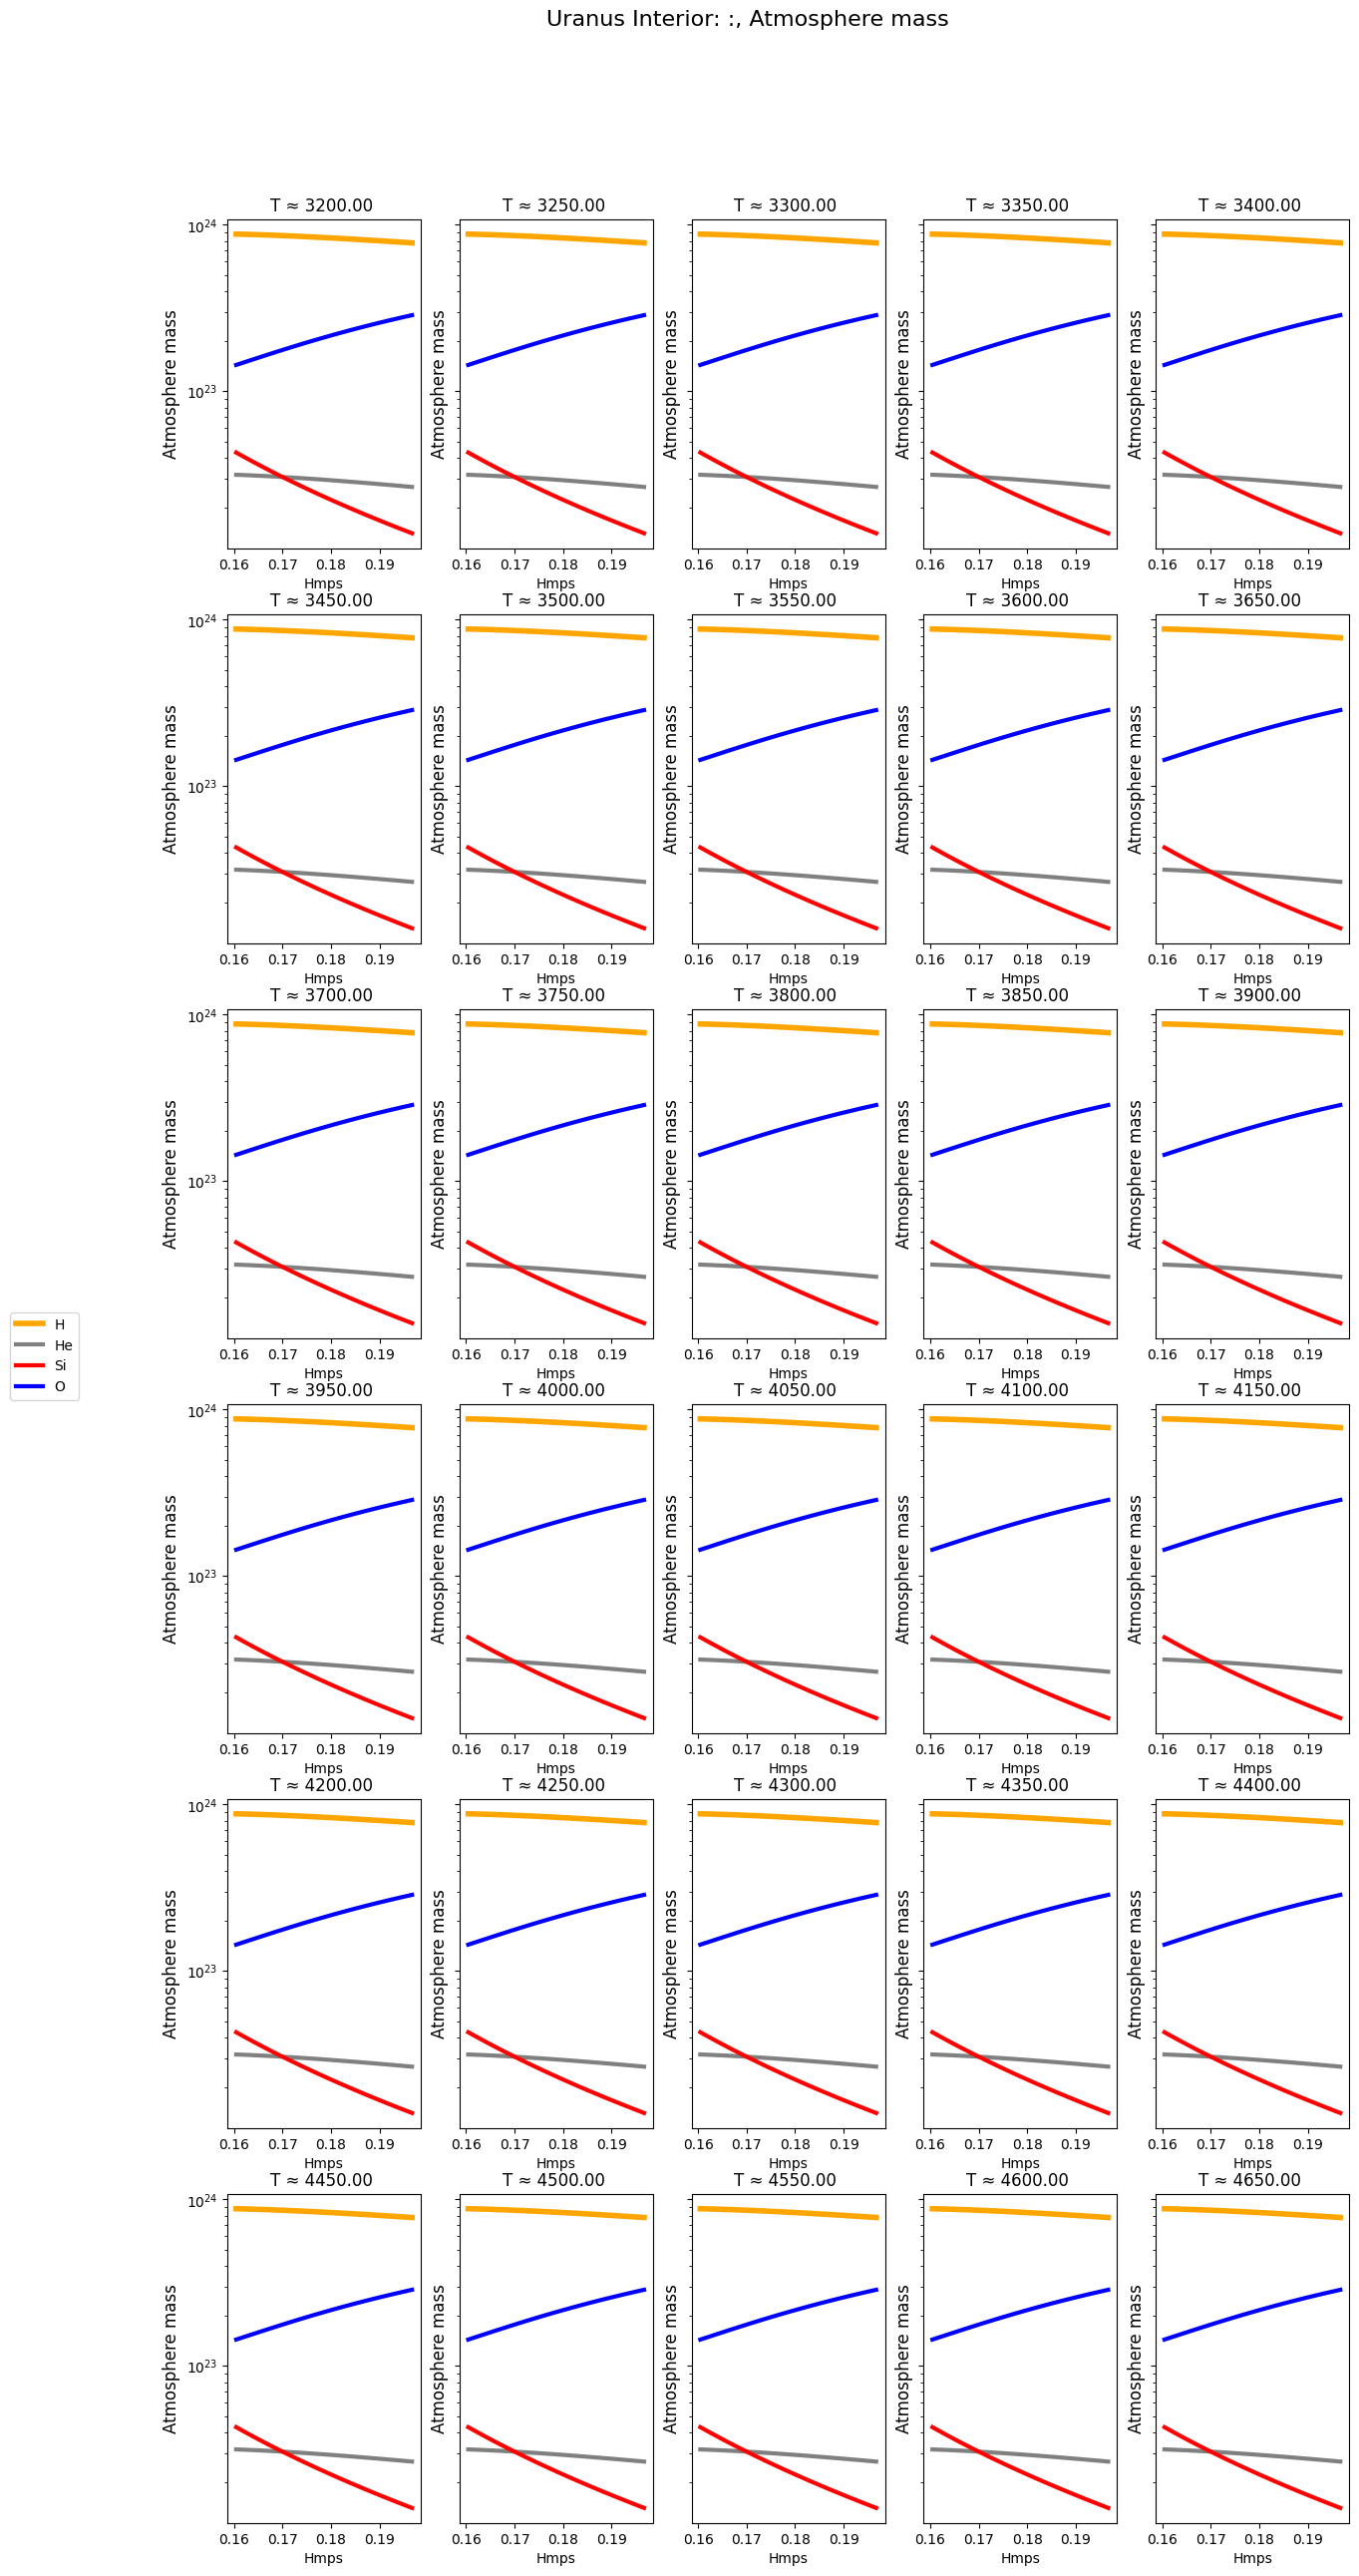

In [38]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], H_mass_atm_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    ax.plot(Hmps[i], He_mass_atm_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], Si_mass_atm_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(Hmps[i], O_mass_atm_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    ax.set_title(r"(a) Real gas")
    #ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"Atmosphere mass", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{Temperatures[i]:.0f}"
    filename = f"./Test_constraints_images/uranus_{Temperatures[i]:.0f}_Atmosphere_mass.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], H_mass_atm_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(Hmps[i], He_mass_atm_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(Hmps[i], Si_mass_atm_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(Hmps[i], O_mass_atm_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
    #axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"Atmosphere mass", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, Atmosphere mass ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_atmo_mass.png", dpi=300, bbox_inches='tight')

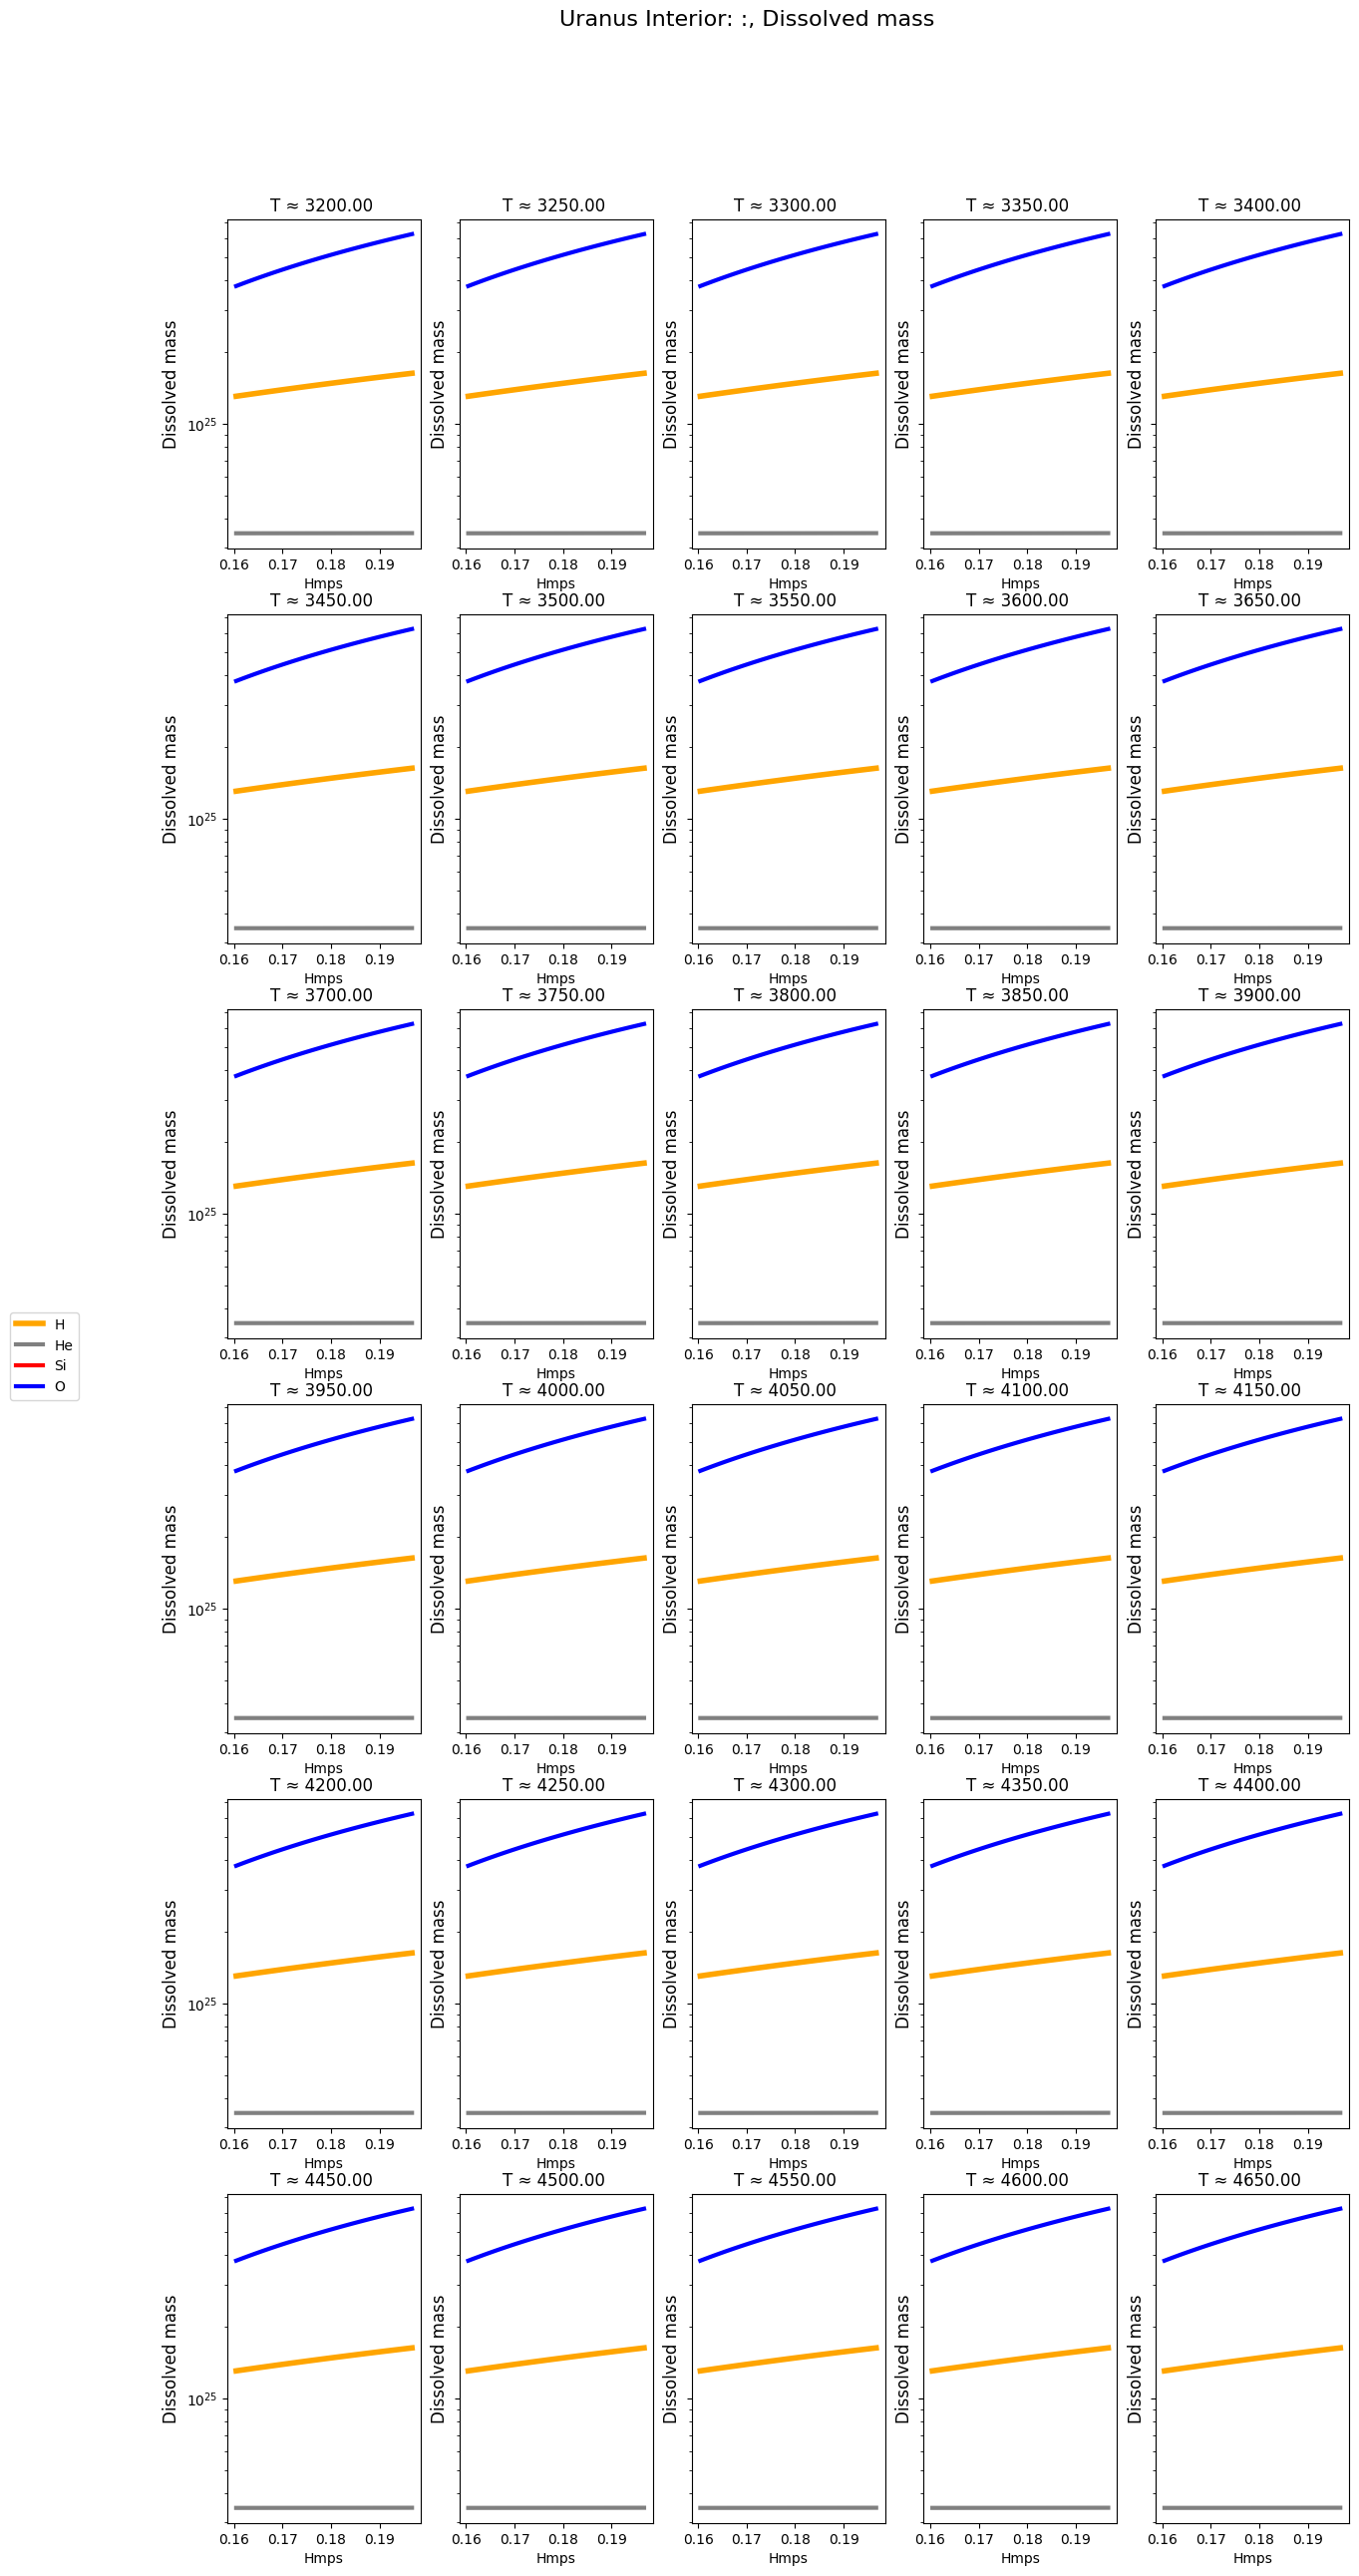

In [39]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], H_mass_melt_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    ax.plot(Hmps[i], He_mass_melt_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], Si_mass_melt_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(Hmps[i], O_mass_melt_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    ax.set_title(r"(a) Real gas")
#    ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"Dissolved mass", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{Temperatures[i]:.0f}"
    filename = f"./Test_constraints_images/uranus_{Temperatures[i]:.0f}_dissolved_mass.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], H_mass_melt_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(Hmps[i], He_mass_melt_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(Hmps[i], Si_mass_melt_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(Hmps[i], O_mass_melt_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
#    axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"Dissolved mass", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, Dissolved mass ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_melt_mass.png", dpi=300, bbox_inches='tight')

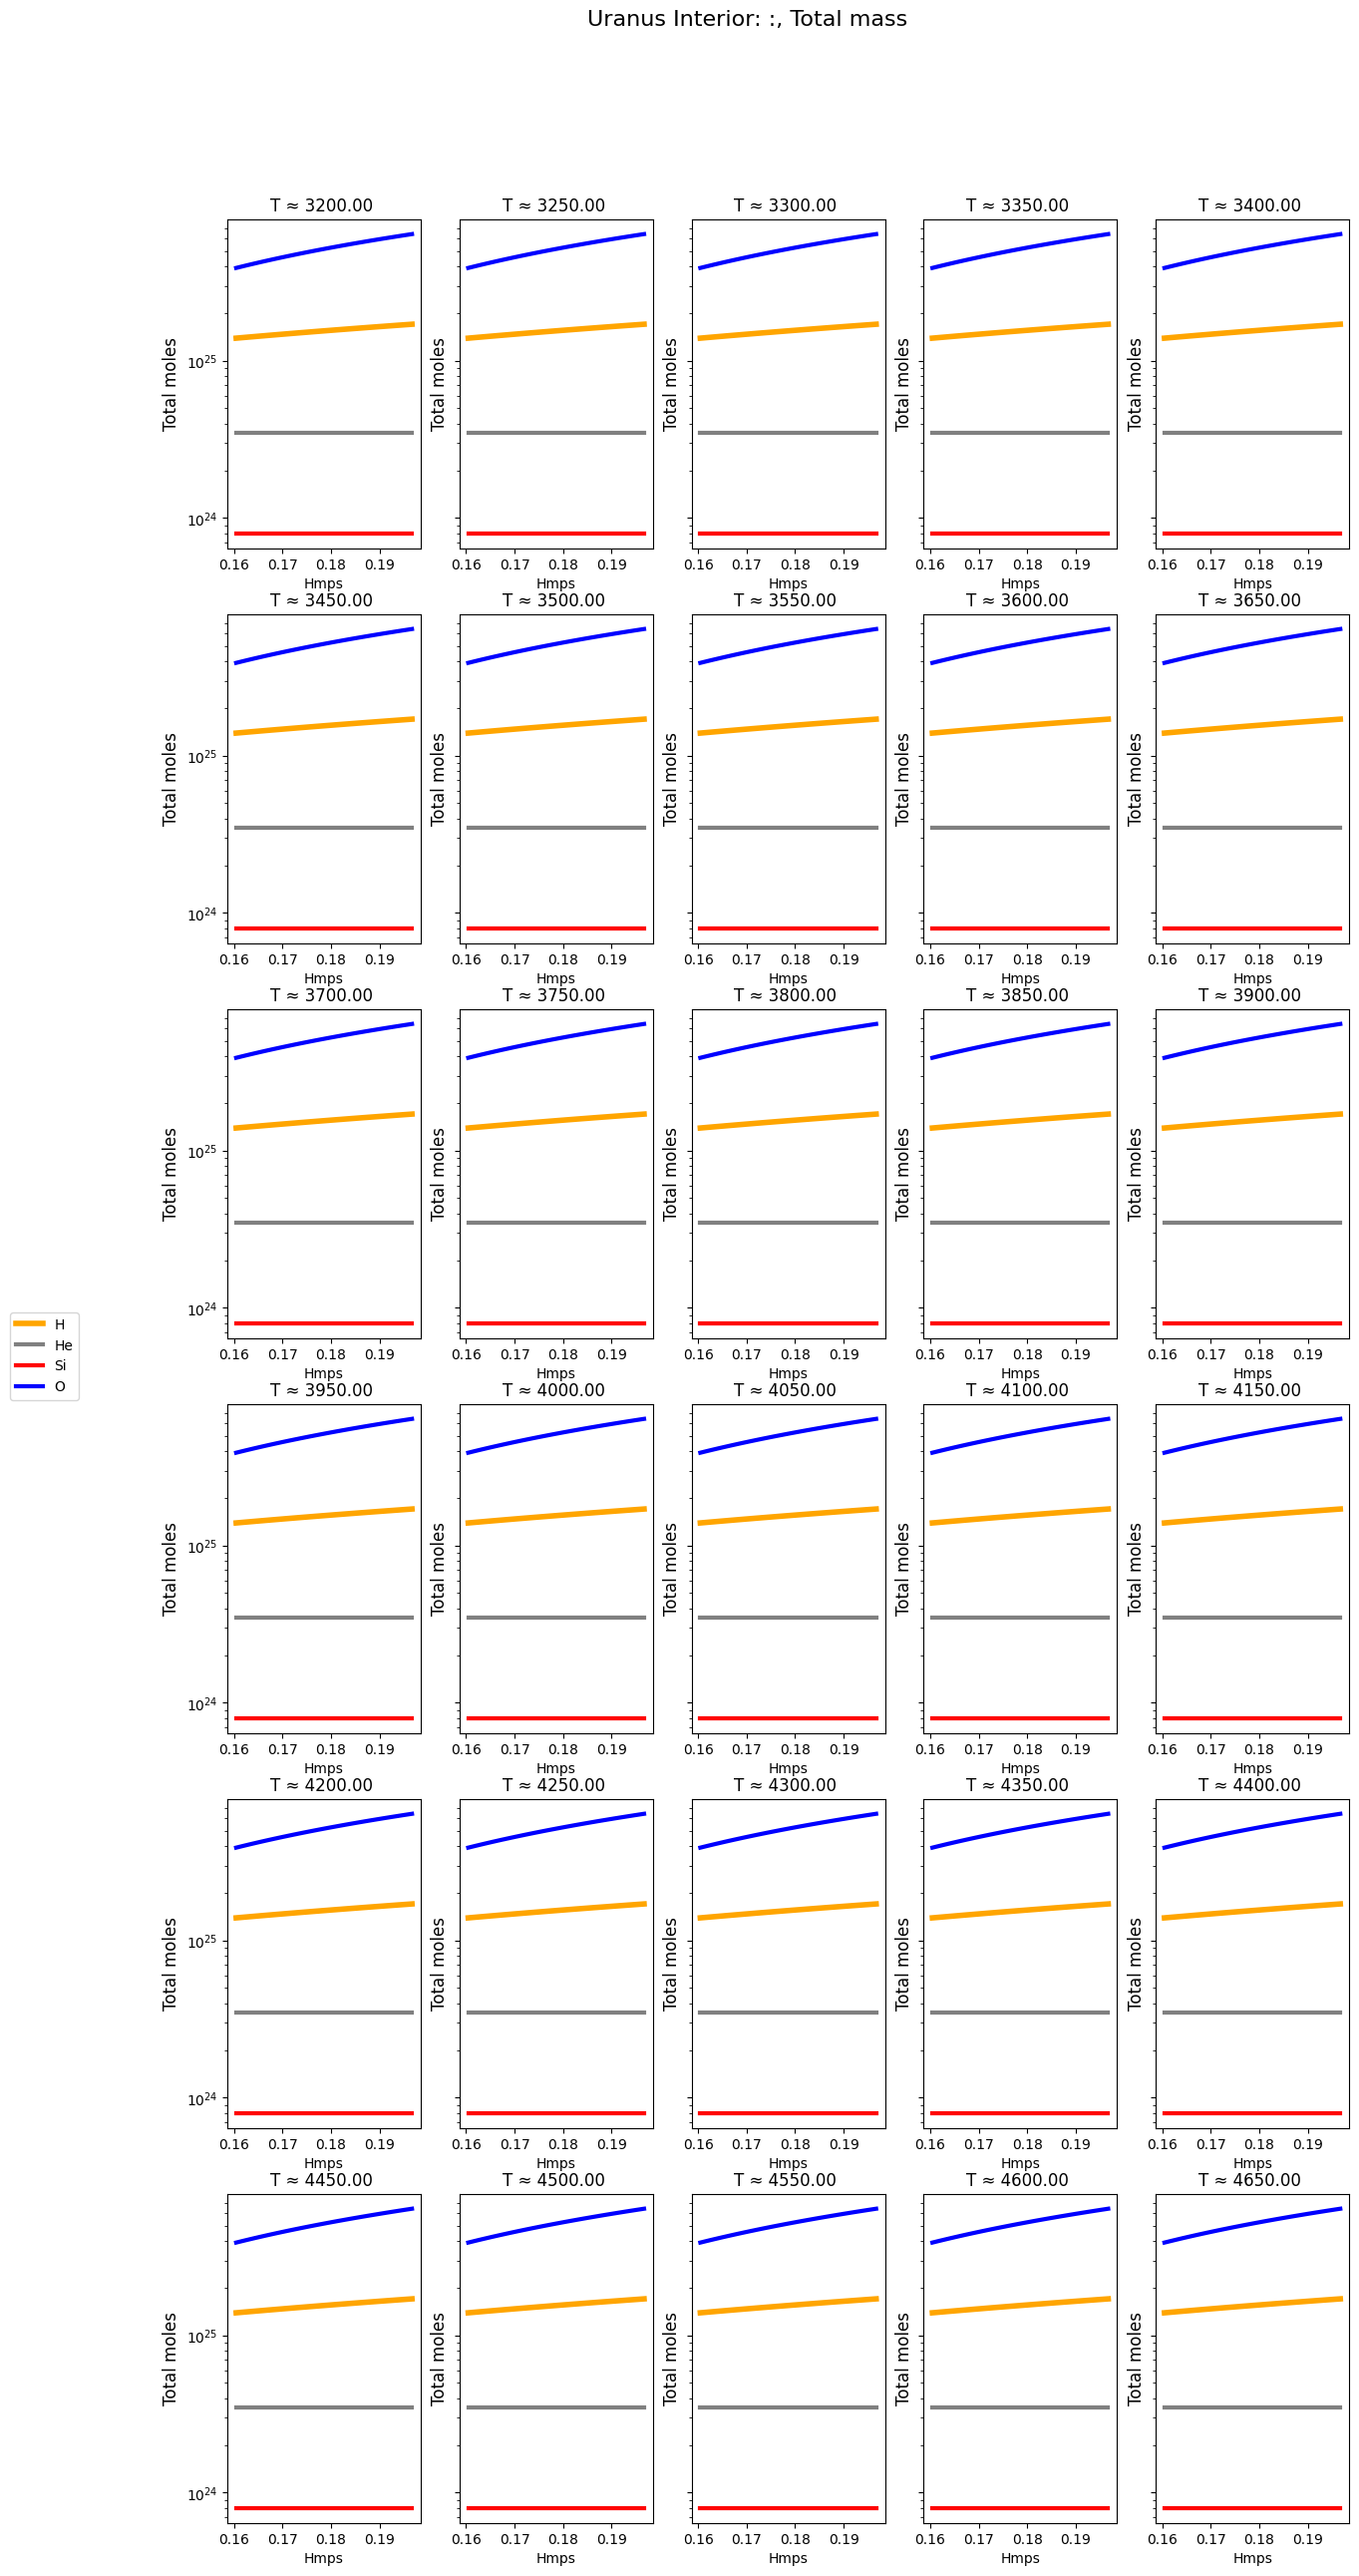

In [40]:
fig_big, axes = plt.subplots(6, 5, figsize=(15, 6 * 5), sharey='row')
axes = axes.flatten()
legend_handles = None
legend_labels = None
Hmps = np.array(H_mass_tot_magma_sol_real) / M_uranus 
for i in range(len(Temperatures)):

    fig, ax = plt.subplots(1, 1, figsize=(15, 20))

    ax.plot(Hmps[i], H_mass_tot_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    ax.plot(Hmps[i], He_mass_tot_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    ax.plot(Hmps[i], Si_mass_tot_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    ax.plot(Hmps[i], O_mass_tot_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    ax.set_title(r"(a) Real gas")
#    ax.set_ylim([1e-3, 2e6])
    ax.set_yscale("log")
    ax.set_xlabel(r"Hmps", fontsize=10)
    ax.set_ylabel(r"Total mass", fontsize=12)
    ax.get_xaxis().set_major_formatter(ScalarFormatter())

    ax.legend(fontsize=10, loc='best') 
        
    plt.tight_layout()
    title = f"Uranus Interior: Temperature core boundary{Temperatures[i]:.0f}"
    filename = f"./Test_constraints_images/uranus_{Temperatures[i]:.0f}_total_mass.png"

    plt.title(title)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    #plt.show()
    plt.close(fig)

    axes[i].plot(Hmps[i], H_mass_tot_magma_sol_real[i], color=color_H, lw=4, ls="-", label="H")
    axes[i].plot(Hmps[i], He_mass_tot_magma_sol_real[i], color=color_He, lw=3, ls="-", label="He")
    axes[i].plot(Hmps[i], Si_mass_tot_magma_sol_real[i], color=color_Si, lw=3, ls="-", label="Si")
    axes[i].plot(Hmps[i], O_mass_tot_magma_sol_real[i], color=color_O, lw=3, ls="-", label="O")

    axes[i].set_title(f"T ≈ {Temperatures[i]:.2f} ")
#    axes[i].set_ylim([1e-3, 2e6])
    axes[i].set_yscale("log")
    axes[i].set_xlabel(r"Hmps", fontsize=10)
    axes[i].set_ylabel(r"Total moles", fontsize=12)
    axes[i].get_xaxis().set_major_formatter(ScalarFormatter())
        # Capture the legend only once
    if legend_handles is None:
        legend_handles, legend_labels = axes[i].get_legend_handles_labels()
    axes[i].legend().remove() 
        
fig_big.subplots_adjust(left=0.15)

# Plot ONE legend on the left side, centered vertically
fig_big.legend(
    legend_handles,
    legend_labels,
    loc='center left',
    bbox_to_anchor=(0, 0.5)   # x-position, y-position
)

fig_big.suptitle(f"Uranus Interior: :, Total mass ", fontsize=16, y=0.95) 
fig_big.savefig(f"./Test_constraints_images/uranus_tot_mass.png", dpi=300, bbox_inches='tight')

# Case 2

In [41]:
#Overall structure 
R_earth = 6.371e6
R_uranus = 2.5388e7 #meters
M_earth = 5.972e24 #kg
M_uranus = 14.536*M_earth

#Boundary inner and outer envelope
M_until_inner_envelope = 0.913*M_uranus 
R_inner_envelope = 0.772*R_uranus
inner_envelope_temperature = 2338.8
inner_en_core_mass_fraction = 0
boundary_mantle_melt_fraction = 0

#Core 
M_core = 0.61*M_earth 
core_mass_fraction_U = 0
core_mantle_melt_fraction = 1.0
R_core = 0.7*R_earth 
core_temperature = 6000

M_heavy = 12.4*M_earth

Z_1 = 0.17
Z_2 = 0.915
Z_solar = 0.0142

ice_rock_ratio = 19

In [42]:
M_inner_envelope = M_until_inner_envelope - M_core

M_rock = M_heavy / (1+ice_rock_ratio)
M_ice = M_heavy - M_rock 

M_H_He_inner_envelope = (1-Z_2)*M_inner_envelope

In [43]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction_U)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme141: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999

MgO_mantlemasspercent_palme14: float = 36.77
Mg_massfraction_palme14: float = round(
    MgO_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction_U)
    / (24.305 + 15.999)
    * 24.305,
    3,
)
O_massfraction_palme142: float = Mg_massfraction_palme14 / 24.305 * 15.999
O_massfraction_palme14 = O_massfraction_palme141 + O_massfraction_palme142
print(O_massfraction_palme14)
print(Si_massfraction_palme14)

0.394198674005231
0.216


In [108]:
Z_CH4 = 0.31
Z_NH3 = 0.08
Z_H2O = 0.61

Z_H2O = np.linspace(0.6,1, 11)
o_kgs_perc = Z_H2O *  15.999 / ( 15.999 + 2 * 1.00794)
h_kgs_perc = Z_H2O *  2 * 1.00794 / ( 15.999 + 2 * 1.00794) #+ Z_NH3 * 3 * 1.00794 / ( 14.0067 + 3 * 1.00794) + Z_CH4 * 4 * 1.00794 / ( 12.0107 + 4 * 1.00794)
n_kgs_perc = Z_NH3 * 14.0067 / ( 14.0067 + 3 * 1.00794)
c_kgs_perc = Z_CH4 * 12.0107 / ( 12.0107 + 4 * 1.00794)

o_kgs_ice = o_kgs_perc*M_ice
h_kgs_ice = h_kgs_perc*M_ice
n_kgs_ice = n_kgs_perc*M_ice
c_kgs_ice = c_kgs_perc*M_ice

In [125]:
#mass_fraction_envelope = np.logspace(0,-10,11)

mass_fraction_envelope = 0.0000000001
mass_fraction_envelope = mass_fraction_envelope#[:, None]
M_H = mass_fraction_envelope*(h_kgs_ice + 0.725*M_H_He_inner_envelope)#[None,:]
M_He = mass_fraction_envelope*0.275*M_H_He_inner_envelope
M_O = mass_fraction_envelope*o_kgs_ice + M_rock*O_massfraction_palme14
M_Si = M_rock*Si_massfraction_palme14
M_Mg = M_rock*Mg_massfraction_palme14
M_C = c_kgs_ice
M_N = n_kgs_ice

In [126]:
mass_constraints = {
    "H": M_H,#.flatten(),
    "He": M_He,
#    "C": M_C,
#    "N": M_N,
    "Si":  M_Si,
    "O": M_O,
#    "Mg": metall * mg_kgs_solar + core_mantle_melt_fraction * mg_kg_magma,
        }
#solver = optx.LevenbergMarquardt, 
solver_parameters = SolverParameters(multistart= 50)
Uranus = Planet(
    surface_temperature=4000,
    planet_mass=M_core,
    mantle_melt_fraction=core_mantle_melt_fraction,
    core_mass_fraction = core_mass_fraction_U,
    surface_radius=R_core,
    )

model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
model_magma_nosol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        )
output_magma_nosol_ideal = model_magma_nosol_ideal.output
output_magma_nosol_ideal.quick_look()
output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
initial_log_number_density = output_magma_nosol_ideal.log_number_density
model_magma_sol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_ideal = model_magma_sol_ideal.output
output_magma_sol_ideal.quick_look()
output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

#last minute solution, reverting to other solver 
model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
initial_log_number_density = output_magma_sol_ideal.log_number_density
model_magma_sol_real.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        solver_parameters= solver_parameters,
        initial_log_number_density=initial_log_number_density
        )
output_magma_sol_real = model_magma_sol_real.output
output_magma_sol_real.quick_look()
output_magma_sol_real.to_excel("Vertical_Test_10")

[18:55:57 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'He_g: IdealGas, NoSolubility')
[18:55:57 - atmodeller.classes             - INFO     ] - reactions = {0: '2.0 H2O_g + 1.0 OSi_g = 1.5 O2_g + 1.0 H4Si_g',
 1: '0.5 O2_g + 1.0 OSi_g = 1.0 O2Si_l',
 2: '1.0 H2O_g = 1.0 H2_g + 0.5 O2_g'}
[18:55:57 - atmodeller.classes             - INFO     ] - Attempting to solve 11 model(s)
[18:55:57 - atmodeller.classes             - WARNING  ] - 1 model(s) failed to converge on the first attempt
[18:55:57 - atmodeller.classes             - WARNING  ] - But don't panic! This can happen when starting from a poor initial guess.
[18:55:57 - atmodeller.classes             - WARNING  ] - Launching multistart (maximum 10 attempts)
[18:55:57 - atmodeller.classes             - WARNING  ] 

# Boundary inner outer envelope

In [1]:
#Overall structure 
R_earth = 6.371e6
R_uranus = 2.5388e7 #meters
M_earth = 5.972e24 #kg
M_uranus = 14.536*M_earth

#Boundary inner and outer envelope
M_until_inner_envelope = 0.913*M_uranus 
R_inner_envelope = 0.772*R_uranus
inner_envelope_temperature = 2338.8
inner_en_core_mass_fraction = 0
boundary_mantle_melt_fraction = 0

#Core 
M_core = 0.61*M_earth 
core_mass_fraction_U = 0
core_mantle_melt_fraction = 1.0
R_core = 0.7*R_earth 
core_temperature = 6000

M_heavy = 12.4*M_earth

Z_1 = 0.17
Z_2 = 0.915
Z_solar = 0.0142
print(Z_2/Z_solar)
ice_rock_ratio = 19

64.43661971830986


In [2]:
M_inner_envelope = M_until_inner_envelope - M_core
M_outer_envelope = M_uranus - M_until_inner_envelope

M_rock = M_heavy / (1+ice_rock_ratio)
M_ice = M_heavy - M_rock 

M_H_He_outer_envelope = (1-Z_1)*M_outer_envelope
M_H_He_inner_envelope = (1-Z_2)*M_inner_envelope
M_H_He_envelope = M_H_He_outer_envelope + M_H_He_inner_envelope
print(M_H_He_envelope / M_earth)
print(M_outer_envelope/ M_earth)
print(M_inner_envelope/ M_earth)

2.12586084
1.2646320000000006
12.661368


In [18]:
Z_CH4 = 0.31
Z_NH3 = 0.08
Z_H2O = np.linspace(0.6,1, 100)
Z_H2O = 0.61


print(Z_H2O)
o_kgs_perc = Z_H2O *  15.999 / ( 15.999 + 2 * 1.00794)
h_kgs_perc = Z_H2O *  2 * 1.00794 / ( 15.999 + 2 * 1.00794) + Z_NH3 * 3 * 1.00794 / ( 14.0067 + 3 * 1.00794) + Z_CH4 * 4 * 1.00794 / ( 12.0107 + 4 * 1.00794)
n_kgs_perc = Z_NH3 * 14.0067 / ( 14.0067 + 3 * 1.00794)
c_kgs_perc = Z_CH4 * 12.0107 / ( 12.0107 + 4 * 1.00794)

o_kgs_ice = o_kgs_perc*M_ice
h_kgs_ice = h_kgs_perc*M_ice
n_kgs_ice = n_kgs_perc*M_ice
c_kgs_ice = c_kgs_perc*M_ice

print(o_kgs_perc)
print(h_kgs_perc)
print(n_kgs_perc)
print(c_kgs_perc)

0.61
0.5417404945245263
0.16037234591534172
0.0657957596127423
0.23209139994738961


In [6]:
#SiO2 for primitive composition of Earth
SiO2_mantlemasspercent_palme14: float = 45.4
total_mantlemasspercent_palme14: float = 98.41
Si_massfraction_palme14: float = round(
    SiO2_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction_U)
    / (28.0855 + 2 * 15.999)
    * 28.0855,
    3,
)

O_massfraction_palme141: float = Si_massfraction_palme14 / 28.0855 * 2 * 15.999

MgO_mantlemasspercent_palme14: float = 36.77
Mg_massfraction_palme14: float = round(
    MgO_mantlemasspercent_palme14
    / total_mantlemasspercent_palme14
    * (1 - core_mass_fraction_U)
    / (24.305 + 15.999)
    * 24.305,
    3,
)
O_massfraction_palme142: float = Mg_massfraction_palme14 / 24.305 * 15.999
O_massfraction_palme14 = O_massfraction_palme141 + O_massfraction_palme142
print(O_massfraction_palme14)
print(Si_massfraction_palme14)

0.394198674005231
0.216


In [7]:
M_H = h_kgs_ice + 0.725*M_H_He_envelope
M_He = 0.275*M_H_He_envelope
M_O = o_kgs_ice + M_rock*O_massfraction_palme14
M_Si = M_rock*Si_massfraction_palme14
M_Mg = M_rock*Mg_massfraction_palme14
M_C = c_kgs_ice
M_N = n_kgs_ice
print(M_H)
print(M_He)
print(M_O)
print(M_Si)
print(M_Mg)
print(M_C)
print(M_N)

1.5005677394590487e+25
3.491301257532001e+24
3.957110624659829e+25
7.9977024e+23
8.33094e+23
1.6327667120922852e+25
4.6287422160779586e+24


In [13]:
eos_models = get_eos_models()
sol_models = get_solubility_models()

H2O_g = Species.create_gas("H2O")
H2O_gs = Species.create_gas("H2O", solubility=sol_models["H2O_peridotite_sossi23"])
H2O_rgs = Species.create_gas(
    "H2O",
    activity=eos_models["H2O_cork_holland98"],
    solubility=sol_models["H2O_peridotite_sossi23"],
)

H2_g = Species.create_gas("H2")
H2_gs = Species.create_gas("H2", solubility=sol_models["H2_basalt_hirschmann12"])
H2_rgs = Species.create_gas(
    "H2", activity=eos_models["H2_chabrier21"], solubility=sol_models["H2_basalt_hirschmann12"]
)

O2_g = Species.create_gas("O2")
O2_rg = Species.create_gas("O2", activity=eos_models["O2_cs_shi92"])

OSi_g = Species.create_gas("OSi")
OSi_rg = Species.create_gas("OSi", activity=eos_models["OSi_rk49_connolly16"])

H4Si_g = Species.create_gas("H4Si")
H4Si_rg = Species.create_gas("H4Si", activity=eos_models["H4Si_wang18"])

O2Si_l = Species.create_condensed("O2Si", state="l")
O2Si_bqz = Species.create_condensed("O2Si", state="bqz")

CO2_g = Species.create_gas("CO2")
CO2_gs = Species.create_gas("CO2", solubility=sol_models["CO2_basalt_dixon95"])
CO2_rgs = Species.create_gas(
    "CO2", solubility=sol_models["CO2_basalt_dixon95"], activity=eos_models["CO2_cs_shi92"]
)
#
CO_g = Species.create_gas("CO")
CO_gs = Species.create_gas("CO", solubility=sol_models["CO_basalt_yoshioka19"])
CO_rgs = Species.create_gas(
    "CO", solubility=sol_models["CO_basalt_yoshioka19"], activity=eos_models["CO_cs_shi92"]
)
#
CH4_g = Species.create_gas("CH4")
CH4_gs = Species.create_gas("CH4", solubility=sol_models["CH4_basalt_ardia13"])
CH4_rgs = Species.create_gas(
    "CH4", solubility=sol_models["CH4_basalt_ardia13"], activity=eos_models["CH4_cs_shi92"]
)
#
N2_g = Species.create_gas("N2")
N2_gs = Species.create_gas("N2", solubility=sol_models["N2_basalt_libourel03"])
N2_rgs = Species.create_gas(
    "N2",solubility=sol_models["N2_basalt_libourel03"],activity=eos_models["N2_cs_saxena87"]
)

NH3_g = Species.create_gas("NH3")
NH3_rg = Species.create_gas("H3N", activity=eos_models["H3N_rk49_reid87"])

He_g = Species.create_gas("He")
He_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
He_rgs = Species.create_gas(
    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
)

Mg_g = Species.create_gas("Mg")
#Mg_gs = Species.create_gas("He", solubility=sol_models["He_basalt_jambon86"])
#Mg_rgs = Species.create_gas(
#    "He", solubility=sol_models["He_basalt_jambon86"], activity=eos_models["He_chabrier21"]
#)

MgO_l = Species.create_condensed("MgO", state="l")
MgO_cr = Species.create_condensed("MgO", state="cr")
MgH_g = Species.create_gas("MgH")
MgOH_g = Species.create_gas("MgOH")

species_HHeCNOSi_magma_nosol_ideal = SpeciesCollection(
    (H2O_g, H2_g, O2_g, OSi_g, H4Si_g, O2Si_l , He_g, CO2_g, CO_g, CH4_g, N2_g, NH3_g, Mg_g, MgO_l, MgH_g, MgOH_g)
     #)
)
species_HHeCNOSi_magma_sol_ideal = SpeciesCollection(
    (H2O_gs, H2_gs, O2_g, OSi_g, H4Si_g, O2Si_l , He_gs, CO2_gs, CO_gs, CH4_gs, N2_gs, NH3_g, Mg_g, MgO_l, MgH_g, MgOH_g)
     #, )
)
species_HHeCNOSi_magma_sol_real = SpeciesCollection(
    (
        H2O_rgs,
        H2_rgs,
        O2_rg,
        OSi_rg,
        H4Si_rg,
        O2Si_l,
        CO2_rgs,
        CO_rgs,
        CH4_rgs,
        N2_rgs,
        NH3_rg,
        He_rgs,
        Mg_g, 
        MgO_l,
        MgH_g,
        MgOH_g
    )
)

In [19]:
mass_constraints = {
    "H": M_H,
    "He": M_He,
    "C": M_C,
    "N": M_N,
    "Si":  M_Si,
    "O": M_O,
    "Mg": M_Mg,
        }
#solver = optx.LevenbergMarquardt, 
solver_parameters = SolverParameters(multistart= 50, max_steps = 1000)
Uranus = Planet(
    surface_temperature=inner_envelope_temperature,
    planet_mass=M_until_inner_envelope,
    mantle_melt_fraction=boundary_mantle_melt_fraction,
    core_mass_fraction = inner_en_core_mass_fraction,
    surface_radius=R_inner_envelope,
    )

model_magma_nosol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_nosol_ideal)
model_magma_nosol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        )
output_magma_nosol_ideal = model_magma_nosol_ideal.output
output_magma_nosol_ideal.quick_look()
output_magma_nosol_ideal.to_excel("HHeCNOSi_magma_nosol_ideal")

model_magma_sol_ideal = InteriorAtmosphere(species_HHeCNOSi_magma_sol_ideal)
initial_log_number_density = output_magma_nosol_ideal.log_number_density
model_magma_sol_ideal.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        initial_log_number_density=initial_log_number_density,
        )
output_magma_sol_ideal = model_magma_sol_ideal.output
output_magma_sol_ideal.quick_look()
output_magma_sol_ideal.to_excel("HHeCNOSi_magma_sol_ideal")

#last minute solution, reverting to other solver 
model_magma_sol_real = InteriorAtmosphere(species_HHeCNOSi_magma_sol_real)
initial_log_number_density = output_magma_sol_ideal.log_number_density
model_magma_sol_real.solve(
        planet=Uranus,
        mass_constraints=mass_constraints,
        solver_parameters= solver_parameters,
        initial_log_number_density=initial_log_number_density
        )
output_magma_sol_real = model_magma_sol_real.output
output_magma_sol_real.quick_look()
output_magma_sol_real.to_excel("Boundaries_Test")

[13:54:06 - atmodeller.classes             - INFO     ] - species = ('H2O_g: IdealGas, NoSolubility', 'H2_g: IdealGas, NoSolubility', 'O2_g: IdealGas, NoSolubility', 'OSi_g: IdealGas, NoSolubility', 'H4Si_g: IdealGas, NoSolubility', 'O2Si_l: CondensateActivity, NoSolubility', 'He_g: IdealGas, NoSolubility', 'CO2_g: IdealGas, NoSolubility', 'CO_g: IdealGas, NoSolubility', 'CH4_g: IdealGas, NoSolubility', 'N2_g: IdealGas, NoSolubility', 'H3N_g: IdealGas, NoSolubility', 'Mg_g: IdealGas, NoSolubility', 'MgO_l: CondensateActivity, NoSolubility', 'HMg_g: IdealGas, NoSolubility', 'HMgO_g: IdealGas, NoSolubility')
[13:54:06 - atmodeller.classes             - INFO     ] - reactions = {0: '1.0 H2_g + 0.5 O2_g = 1.0 H2O_g',
 1: '1.0 CO2_g = 0.5 O2_g + 1.0 CO_g',
 2: '2.0 H2_g + 1.0 CO2_g = 1.0 O2_g + 1.0 CH4_g',
 3: '2.0 H2_g + 1.0 O2Si_l = 1.0 O2_g + 1.0 H4Si_g',
 4: '1.5 H2_g + 0.5 N2_g = 1.0 H3N_g',
 5: '1.0 O2Si_l = 0.5 O2_g + 1.0 OSi_g',
 6: '0.5 O2_g + 1.0 Mg_g = 1.0 MgO_l',
 7: '0.5 H2_g +